# Final Anomaly Detection 

### Original Data and Other Necessary Data Pieces

Here are all the libraries and modules we will need.

In [1]:
from pyCP_APR import CP_APR

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import os.path
import gzip
import shutil
import datetime
import networkx as nx
import pickle
from scipy import stats
from scipy import sparse
import bz2
import random
import regex as re
from tqdm.notebook import tqdm
import scipy

from sklearn.preprocessing import Normalizer, StandardScaler, MinMaxScaler
from sklearn.ensemble import IsolationForest
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.neighbors import LocalOutlierFactor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, matthews_corrcoef, cohen_kappa_score, accuracy_score, average_precision_score, roc_auc_score

from IPython.display import clear_output

import tensorflow as tf
import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tqdm.keras import TqdmCallback

We set seeds to ensure reproducibility.

In [2]:
os.environ['PYTHONHASHSEED'] = '42'
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

In [3]:
os.chdir(r'C:\Users\corri\OneDrive\Documents\GitHub\Advanced-Cyber-Analytics-for-Attack-Detection\Anomaly Detection')

Here we import the original data - these are the data summaries.

In [4]:
try:
    print('Attempting to read entire data set.')
    authentication_data = pd.read_csv('../Data/Authentication data.gz', compression='gzip', index_col = 0)
    process_data = pd.read_csv('../Data/Process data.gz', compression='gzip', index_col = 0)
except:
    clear_output()
    print('Unable to read entire data set, reading from original files.')
    rootdir = 'C:/Users/corri/OneDrive/Documents/Uni/Postgraduate/Final Project/LANL/ATI Data/Summaries/wls'
    unzippeddir = 'C:/Users/corri/OneDrive/Documents/Uni/Postgraduate/Final Project/LANL/ATI Data/Summaries/wls/Unzipped'
    frames = []

    count = 0
    
    for subdir, dirs, files in os.walk(rootdir):
        for file in files:
            if file[-3:] == '.gz':
                filedir = rootdir + '/' + file
                with gzip.open(filedir) as f:
                    df = pd.read_csv(filedir, header=None)
                    frames.append(df)
                if 'authentications' in str(file):
                    count = count + len(df)
    
    df = pd.concat(frames)

    authentication_data = df[:count]
    authentication_data.columns = ['UserName', 'SrcDevice','DstDevice', 'Authent Type', 'Failure', 'DailyCount']

    process_data = df[count:]
    process_data = process_data[[0,1,2,3,4]]
    process_data.columns = ['UserName', 'Device', 'ProcessName', 'ParentProcessName', 'DailyCount']

    authentication_data.to_csv('../Data/Authentication data.gz', header=True, compression='gzip')
    process_data.to_csv('../Data/Process data.gz', header=True, compression='gzip')

Attempting to read entire data set.


C:\Users\corri\anaconda3\lib\site-packages\numpy\lib\arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


The list of known red team users, which is assumed to be comprehensive, is required later on for analysis of techniques. We'll also obtain a list of non red-team users and a sample of them to employ when testing the algorithms.

In [5]:
rt_usernames = list(pd.read_csv('../Data/AuthUserNames.txt', header=None)[0])
non_rt_users = [un for un in authentication_data['UserName'].unique() if un not in rt_usernames]
non_rt_sample = pickle.load(open('Random Sample of Non Red Team Usernames.p','rb'))

For data creation later we require a list of authentication types - this can be created here.

In [6]:
a_t = list(authentication_data['Authent Type'].unique())
AT_dict = { i : a_t[i] for i in range(0, len(a_t) ) }

Finally, we require a list of the seperation points in our data frame. Each day can be seperated out by indexing and we find the indices here.

In [7]:
auth_index_list = authentication_data.index.tolist()
auth_start_days = [i for i, e in enumerate(auth_index_list) if e == 0]
auth_start_days.append(len(authentication_data))

### Data Creation for Anomaly Detction

#### Main Data Creation Functions

This first function is used to split a data frame into equal chunks. Since we need to split each day into 8/24 hours we use this function to split into equal time periods - this may not be perfectly representitive of the actual hour split but should be a good estimate since we don't have the original time stamps.

In [8]:
def split_dataframe(df,n):
    chunks = list()
    chunk_size = int(np.round(df.shape[0]/n))
    num_chunks = n
    for i in range(num_chunks):
        if i != num_chunks-1:
            chunks.append(df[i*chunk_size:(i+1)*chunk_size])
        else:
            chunks.append(df[i*chunk_size:])
    return chunks

In [9]:
def auth_type_un_df(user,n):
    auth_type_df = pd.DataFrame(index = list(authentication_data['Authent Type'].unique()))
    n = n
    auth_type_dict = {}
    
    for i in range(len(auth_start_days)-1):
        chunks = split_dataframe(authentication_data[auth_start_days[i]:auth_start_days[i+1]],n)
        for j in range(n):
                data = chunks[j]
                auth_type_data = data[data['UserName'] == user].groupby('Authent Type')['DailyCount'].sum()
                auth_type_dict[i*n + j] = auth_type_df.index.to_series().map(auth_type_data.to_dict())
    
    auth_type_df = pd.DataFrame(data=auth_type_dict,index = list(authentication_data['Authent Type'].unique()))
    auth_type_df = auth_type_df.transpose()
    auth_type_df = auth_type_df.fillna(0)
    
    return auth_type_df

#### Authentication Type Data

This function creates the authentication type data frames . It takes as input a username and a split by number (8/24) and returns a data frame of the user's authentiation events split by type over 90 days, split by 8/24 hours.

In [10]:
def auth_type_un_df(user,n):
    auth_type_df = pd.DataFrame(index = list(authentication_data['Authent Type'].unique()))
    n = n
    auth_type_dict = {}
    
    for i in range(len(auth_start_days)-1):
        chunks = split_dataframe(authentication_data[auth_start_days[i]:auth_start_days[i+1]],n)
        for j in range(n):
                data = chunks[j]
                auth_type_data = data[data['UserName'] == user].groupby('Authent Type')['DailyCount'].sum()
                auth_type_dict[i*n + j] = auth_type_df.index.to_series().map(auth_type_data.to_dict())
    
    auth_type_df = pd.DataFrame(data=auth_type_dict,index = list(authentication_data['Authent Type'].unique()))
    auth_type_df = auth_type_df.transpose()
    auth_type_df = auth_type_df.fillna(0)
    
    return auth_type_df

#### Various Count Data

This function creates a data frame of other features. It includes counts from various possible features that we could've chosen.

In [11]:
def feature_generation(user,n):
    
    feat_dict = {}
    # for reference (not used)
    day_dict = {0:'Monday',1:'Tuesday',2:'Wednesday',3:'Thursday',4:'Friday',5:'Saturday',6:'Sunday'}
    
    for i in range(len(auth_start_days)-1):
        # gives access to a day for the NN - assume start on a monday based on EDA
        day = i%7
        chunks = split_dataframe(authentication_data[auth_start_days[i]:auth_start_days[i+1]],n)
        for j in range(n):
                hour = j
                data = chunks[j]
                authents = len(data[data['UserName'] == user])
                failures = len(data[(data['UserName'] == user) & (data['Failure'] == 1)])
                srcunique = len(data[data['UserName'] == user]['SrcDevice'].unique())
                dstunique = len(data[data['UserName'] == user]['DstDevice'].unique())
                uniquepairs = len(data.groupby(['SrcDevice','DstDevice']).size())
                feat_dict[i*n + j] = [srcunique,dstunique,authents,failures]
                #feat_dict[i*n + j] = [day,hour,srcunique,dstunique,uniquepairs,authents,failures]
                
    df = pd.DataFrame(data=feat_dict,index =  ['SrcUnique','DstUnique','Authentications','Failures'])
    #df = pd.DataFrame(data=feat_dict,index =  ['Day','Hour','SrcUnique','DstUnique','UniquePairs','Authentications','Failures'])
    df = df.transpose()
    df = df.fillna(0)
    
    return df

#### Adjacency Data

The data created here is the adjacency matrix between usernames and destination devices they authenticate with.

In [12]:
try:
    print('Reading Data.')
    data_frame_list_uase = pickle.load(open('C:/Users/corri/OneDrive/Documents/Uni/Postgraduate/Final Project/Data Frame List UASE.p','rb'))
    index_sparse = pickle.load(open('Index UASE.p','rb'))
    columns_sparse = pickle.load(open('Columns UASE.p','rb'))
    
except:
    clear_output()
    print('Creating Data Frames.')
    data_frame_list_uase = []

    start_time = datetime.datetime.now()

    for i in tqdm(range(len(auth_start_days)-1)):

        data_frame_ind = pd.DataFrame(index = list(authentication_data['DstDevice'].unique()))

        chunk = authentication_data[auth_start_days[i]:auth_start_days[i+1]]
        data_un ={}
        for user in authentication_data['UserName'].unique():
            dstdevice_data = chunk[chunk['UserName'] == user].groupby('DstDevice').size()
            data_un[user] = data_frame_ind.index.to_series().map(dstdevice_data.to_dict())

        data_frame_ind = pd.DataFrame(data=data_un,index = list(authentication_data['DstDevice'].unique()))
        data_frame_ind = data_frame_ind.notnull().astype('int')
        data_frame_ind = data_frame_ind.fillna(0)
        A = np.array(data_frame_ind)
        sA = sparse.csr_matrix(A)
        data_frame_list_uase.append(sA)    

    index_sparse = data_frame_ind.index
    columns_sparse = data_frame_ind.columns
    pickle.dump(data_frame_list_uase, open('Data Frame List UASE.p', 'wb'))
    pickle.dump(index_sparse, open('Index UASE.p', 'wb'))
    pickle.dump(columns_sparse, open('Columns UASE.p', 'wb'))
    print(datetime.datetime.now()-start_time)

Reading Data.


#### Supervised Data

We turn our anomaly detection exercise into a supervised problem here.

In [13]:
def feature_generation_supervised(user,n,anom):
    
    feat_dict = {}
    # for reference (not used)
    day_dict = {0:'Monday',1:'Tuesday',2:'Wednesday',3:'Thursday',4:'Friday',5:'Saturday',6:'Sunday'}
    
    for i in range(len(auth_start_days)-1):
        # gives access to a day for the NN - assume start on a monday based on EDA
        day = i%7
        chunks = split_dataframe(authentication_data[auth_start_days[i]:auth_start_days[i+1]],n)
        for j in range(n):
            
            hour = j
            data = chunks[j]
            
            if 57 <= i+1 <= 82 and anom==True:
                anombool = 1
            else:
                anombool = 0

            authents = len(data[data['UserName'] == user])
            failures = len(data[(data['UserName'] == user) & (data['Failure'] == 1)])
            srcunique = len(data[data['UserName'] == user]['SrcDevice'].unique())
            dstunique = len(data[data['UserName'] == user]['DstDevice'].unique())
            uniquepairs = len(data.groupby(['SrcDevice','DstDevice']).size())
            feat_dict[i*n + j] = [user,srcunique,dstunique,authents,failures,anombool]
            #feat_dict[i*n + j] = [day,hour,srcunique,dstunique,uniquepairs,authents,failures]
                
    df = pd.DataFrame(data=feat_dict,index =  ['UserName','SrcUnique','DstUnique','Authentications','Failures','Anomaly'])
    #df = pd.DataFrame(data=feat_dict,index =  ['Day','Hour','SrcUnique','DstUnique','UniquePairs','Authentications','Failures'])
    df = df.transpose()
    df = df.fillna(0)
    
    return df

In [14]:
def MCC(tp,tn,fp,fn):
    acc = (tp+tn)/(tp+tn+fp+fn)
    prec = tp / (tp+fp)
    rec = tp /(tp+fn)
    fpr = fp / (fp+tn)
    mcc = ((tp * tn) - (fp * fn)) / np.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))
    
    return np.array([acc,prec,rec,fpr])*100,mcc

### Anomaly Detection

#### Isolation Forest

In [15]:
def scaled_iso(data,plot=False,c='auto'):
    
    # scaling
    scaler = StandardScaler()
    scaled_data = pd.DataFrame(scaler.fit_transform(data))
    
    # isolation forest predictions
    if_model = IsolationForest(contamination=c)
    if_predictions = if_model.fit_predict(data)
    
    if plot == True:
        
        # PCA reduction for plotting
        pca = PCA(n_components=2)
        auth_types_pca = pd.DataFrame(pca.fit_transform(data))
        
        # finding anomaly locations
        a_if = auth_types_pca.loc[if_predictions == -1]
        
        anomalies = auth_types_pca.loc[a_if.index]
        
        fig, ax = plt.subplots(figsize=(20,6))
        ax.plot(auth_types_pca[0], auth_types_pca[1], color='black', label='Normal')
        ax.scatter(anomalies[0], anomalies[1], color='red', label='Anomaly')
        ax.set_xlabel("Time")
        ax.set_ylabel("Number of Events")
        ax.text(0,auth_types_pca[1].max()-0.1,('Number of IF anomalies found: {}.'.format(len(a_if))))
        plt.legend(loc=1)
        plt.show()
        
    else:
        a_if = data.loc[if_predictions == -1]
        
        anomalies = data.loc[a_if.index]
    
    return anomalies

In [16]:
def simple_iso_eval(anomaly_bools,anomalies,usernames,type_un):
    
    non_anom = []
    for i in range(len(anomaly_bools)):
        if anomaly_bools[i][0] == 0:    
            non_anom.append(anomaly_bools[i][1])

    anom = []
    for i in range(len(anomaly_bools)):
        if anomaly_bools[i][0] != 0:    
            anom.append(anomaly_bools[i][1])
    
    print('{} of the {} usernames were identified to have anomalies out of {} {} usernames. The folloiwng usernames were found to have no anomalies'.
          format(len(np.where(np.array([i[0] for i in anomaly_bools]) > 0)[0]),type_un,len(anomaly_bools),type_un))
    print('--------------------------------------------------------------------------------------------')        
    print(', '.join(map(str,non_anom)))
    
    perc = 100*len(anomalies)/len(authentication_data[authentication_data['UserName'].isin(usernames)])
    print('{:.2f}% of the {} data was identified as anomalous.'.format(perc,type_un))
    
    anomalies.head()
    
    return

In [17]:
rt_if_anomalies = []
anomaly_count_rt_if = []
anomaly_bool_rt_if = []

for un in tqdm(rt_usernames):
    data = auth_type_un_df(un,24)
    anomalies = scaled_iso(data)
    rt_if_anomalies.append(anomalies)
    if len(anomalies) != 0:
        anomaly_count_rt_if.append(len(anomalies))
        anomaly_bool_rt_if.append((1,un))
    else:
        anomaly_count_rt_if.append(0)
        anomaly_bool_rt_if.append((0,un))
rt_if_anomalies = pd.DataFrame(rt_if_anomalies)
simple_iso_eval(anomaly_bool_rt_if,rt_if_anomalies,rt_usernames,'red team')

  0%|          | 0/99 [00:00<?, ?it/s]

99 of the red team usernames were identified to have anomalies out of 99 red team usernames. The folloiwng usernames were found to have no anomalies
--------------------------------------------------------------------------------------------

0.07% of the red team data was identified as anomalous.


C:\Users\corri\anaconda3\lib\site-packages\pandas\core\internals\construction.py:538: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  values = np.array([convert(v) for v in values])


In [18]:
nonrt_if_anomalies = []
anomaly_count_nonrt_if = []
anomaly_bool_nonrt_if = []

for un in tqdm(non_rt_sample):
    data = auth_type_un_df(un,24)
    anomalies = scaled_iso(data)
    nonrt_if_anomalies.append(anomalies)
    if len(anomalies) != 0:
        anomaly_count_nonrt_if.append(len(anomalies))
        anomaly_bool_nonrt_if.append((1,un))
    else:
        anomaly_count_nonrt_if.append(0)
        anomaly_bool_nonrt_if.append((0,un))
nonrt_if_anomalies = pd.DataFrame(nonrt_if_anomalies)
simple_iso_eval(anomaly_bool_nonrt_if,nonrt_if_anomalies,non_rt_sample,'normal')

  0%|          | 0/200 [00:00<?, ?it/s]

200 of the normal usernames were identified to have anomalies out of 200 normal usernames. The folloiwng usernames were found to have no anomalies
--------------------------------------------------------------------------------------------

0.21% of the normal data was identified as anomalous.


C:\Users\corri\anaconda3\lib\site-packages\pandas\core\internals\construction.py:538: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  values = np.array([convert(v) for v in values])


In [62]:
MCC(95,0,200,0)

<ipython-input-14-8a0dabc72e3b>:6: RuntimeWarning: invalid value encountered in double_scalars
  mcc = ((tp * tn) - (fp * fn)) / np.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))


(array([ 32.20338983,  32.20338983, 100.        , 100.        ]), nan)

#### LOF

In [19]:
def scaled_lof(data,plot=False,c='auto'):
    
    # scaling
    scaler = StandardScaler()
    scaled_data = pd.DataFrame(scaler.fit_transform(data))
    
    # local outlier factor predictions
    lof = LocalOutlierFactor(n_neighbors=2)
    lof_predictions = lof.fit_predict(data)
    
    if plot == True:
        
        # PCA reduction for plotting
        pca = PCA(n_components=2)
        auth_types_pca = pd.DataFrame(pca.fit_transform(data))
        
        # finding anomaly locations
        a_lof = auth_types_pca.loc[lof_predictions == -1]
        
        anomalies = auth_types_pca.loc[a_lof.index]
        
        fig, ax = plt.subplots(figsize=(20,6))
        ax.plot(auth_types_pca[0], auth_types_pca[1], color='black', label='Normal')
        ax.scatter(anomalies[0], anomalies[1], color='red', label='Anomaly')
        ax.set_xlabel("Time")
        ax.set_ylabel("Number of Events")
        ax.text(0,auth_types_pca[1].max()-0.1,('Number of LOF anomalies found: {}.'.format(len(a_lof))))
        plt.legend(loc=1)
        plt.show()
        
    else:
        a_lof = data.loc[lof_predictions == -1]
        
        anomalies = data.loc[a_lof.index]
    
    return anomalies

In [20]:
rt_lof_anomalies = []
anomaly_count_rt_lof = []
anomaly_bool_rt_lof = []

for un in tqdm(rt_usernames):
    data = auth_type_un_df(un,24)
    anomalies = scaled_lof(data)
    rt_lof_anomalies.append(anomalies)
    if len(anomalies) != 0:
        anomaly_count_rt_lof.append(len(anomalies))
        anomaly_bool_rt_lof.append((1,un))
    else:
        anomaly_count_rt_lof.append(0)
        anomaly_bool_rt_lof.append((0,un))
rt_lof_anomalies = pd.DataFrame(rt_lof_anomalies)
simple_iso_eval(anomaly_bool_rt_lof,rt_lof_anomalies,rt_usernames,'red team')

  0%|          | 0/99 [00:00<?, ?it/s]

99 of the red team usernames were identified to have anomalies out of 99 red team usernames. The folloiwng usernames were found to have no anomalies
--------------------------------------------------------------------------------------------

0.07% of the red team data was identified as anomalous.


C:\Users\corri\anaconda3\lib\site-packages\pandas\core\internals\construction.py:538: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  values = np.array([convert(v) for v in values])


In [21]:
nonrt_lof_anomalies = []
anomaly_count_nonrt_lof = []
anomaly_bool_nonrt_lof = []

for un in tqdm(non_rt_sample):
    data = auth_type_un_df(un,24)
    anomalies = scaled_lof(data)
    nonrt_lof_anomalies.append(anomalies)
    if len(anomalies) != 0:
        anomaly_count_nonrt_lof.append(len(anomalies))
        anomaly_bool_nonrt_lof.append((1,un))
    else:
        anomaly_count_nonrt_lof.append(0)
        anomaly_bool_nonrt_lof.append((0,un))
nonrt_lof_anomalies = pd.DataFrame(nonrt_lof_anomalies)
simple_iso_eval(anomaly_bool_nonrt_lof,nonrt_lof_anomalies,non_rt_sample,'normal')

  0%|          | 0/200 [00:00<?, ?it/s]

198 of the normal usernames were identified to have anomalies out of 200 normal usernames. The folloiwng usernames were found to have no anomalies
--------------------------------------------------------------------------------------------
User515596, User392061
0.21% of the normal data was identified as anomalous.


C:\Users\corri\anaconda3\lib\site-packages\pandas\core\internals\construction.py:538: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  values = np.array([convert(v) for v in values])


In [61]:
MCC(95,2,198,0)

(array([ 32.88135593,  32.42320819, 100.        ,  99.        ]),
 0.056941380551516554)

#### Isolation Forest and Local Outlier Factor Detection

In [22]:
def scaled_iso_lof(data,plot=False,c='auto'):
    
    # scaling
    scaler = StandardScaler()
    scaled_data = pd.DataFrame(scaler.fit_transform(data))
    
    # isolation forest predictions
    if_model = IsolationForest(contamination=c)
    if_predictions = if_model.fit_predict(data)
    
    # local outlier factor predictions
    lof = LocalOutlierFactor(n_neighbors=2)
    lof_predictions = lof.fit_predict(data)
    
    if plot == True:
        
        # PCA reduction for plotting
        pca = PCA(n_components=2)
        auth_types_pca = pd.DataFrame(pca.fit_transform(data))
        
        # finding anomaly locations
        a_if = auth_types_pca.loc[if_predictions == -1]
        a_lof = auth_types_pca.loc[lof_predictions == -1]
        
        anomalies = auth_types_pca.loc[list(set(a_lof.index) & set(a_if.index))]
        
        fig, ax = plt.subplots(figsize=(20,6))
        ax.plot(auth_types_pca[0], auth_types_pca[1], color='black', label='Normal')
        ax.scatter(anomalies[0], anomalies[1], color='red', label='Anomaly')
        ax.set_xlabel("Time")
        ax.set_ylabel("Number of Events")
        ax.text(0,auth_types_pca[1].max()-0.1,('Number of combined anomalies found: {}. \n Number of LOF anomalies found: {}. \n Number of IF anomalies found: {}.'.format(len(anomalies), len(a_lof), len(a_if))))
        plt.legend(loc=1)
        plt.show()
        
    else:
        a_if = data.loc[if_predictions == -1]
        a_lof = data.loc[lof_predictions == -1]
        
        anomalies = data.loc[list(set(a_lof.index) & set(a_if.index))]
    
    return anomalies

In [23]:
rt_if_lof_anomalies = []
anomaly_count = []
anomaly_bool = []

for un in tqdm(rt_usernames):
    data = auth_type_un_df(un,24)
    anomalies = scaled_iso_lof(data)
    rt_if_lof_anomalies.append(anomalies)
    if len(anomalies) != 0:
        anomaly_count.append(len(anomalies))
        anomaly_bool.append((1,un))
    else:
        anomaly_count.append(0)
        anomaly_bool.append((0,un))
rt_if_lof_anomalies = pd.DataFrame(rt_if_lof_anomalies)
simple_iso_eval(anomaly_bool,rt_if_lof_anomalies,rt_usernames,'red team')

  0%|          | 0/99 [00:00<?, ?it/s]

99 of the red team usernames were identified to have anomalies out of 99 red team usernames. The folloiwng usernames were found to have no anomalies
--------------------------------------------------------------------------------------------

0.07% of the red team data was identified as anomalous.


C:\Users\corri\anaconda3\lib\site-packages\pandas\core\internals\construction.py:538: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  values = np.array([convert(v) for v in values])


In [24]:
rt_if_lof_anomalies_n = []
anomaly_count_n = []
anomaly_bool_n = []

for un in tqdm(non_rt_sample):
    data = auth_type_un_df(un,24)
    anomalies = scaled_iso_lof(data)
    rt_if_lof_anomalies_n.append(anomalies)
    if len(anomalies) != 0:
        anomaly_count_n.append(len(anomalies))
        anomaly_bool_n.append((1,un))
    else:
        anomaly_count_n.append(0)
        anomaly_bool_n.append((0,un))

rt_if_lof_anomalies_n = pd.DataFrame(rt_if_lof_anomalies_n)
        
simple_iso_eval(anomaly_bool_n,rt_if_lof_anomalies_n,non_rt_sample,'normal')

  0%|          | 0/200 [00:00<?, ?it/s]

198 of the normal usernames were identified to have anomalies out of 200 normal usernames. The folloiwng usernames were found to have no anomalies
--------------------------------------------------------------------------------------------
User515596, User392061
0.21% of the normal data was identified as anomalous.


C:\Users\corri\anaconda3\lib\site-packages\pandas\core\internals\construction.py:538: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  values = np.array([convert(v) for v in values])


#### Auto Encoder AD

The first function allows us to work back from the anomalies produced by the auto-encoder to obtain the original anomalies.

In [25]:
def ae_orig_finder(user,n,idx):
    
    j_idx = idx % n
    i_idx = int(idx/n)

    chunks = split_dataframe(authentication_data[auth_start_days[i_idx]:auth_start_days[i_idx+1]],n)
    data = chunks[j_idx][chunks[j_idx]['UserName'] == user]
    
    return data

Here we define our best auto encoder anomaly detection function from the 6 we built - built from https://csce.ucmss.com/cr/books/2019/LFS/CSREA2019/ICA2282.pdf

In [26]:
def ae_anomaly_finder(user,n,BATCH_SIZE=64, EPOCHS=1000):
    
    clear_output()
    
    # get the data frame of features
    df = feature_generation(user,n)
    x_train_ae = np.concatenate([np.array(df[0:57*n]),np.array(df[82*n:])])
    x_test_ae = np.array(df[57*n:82*n])
    
    # create our scaling pipeline
    pipeline = Pipeline([('normalizer', Normalizer()),
                    ('scaler', MinMaxScaler())])
    pipeline.fit(x_train_ae)
    x_train_ae = pipeline.transform(x_train_ae)
    x_test_ae = pipeline.transform(x_test_ae)
    
    # define neural network parameters
    input_dim = x_train_ae.shape[1]
    BATCH_SIZE = BATCH_SIZE
    EPOCHS = EPOCHS

    # define the autoencoder
    autoencoder =Sequential([

        # deconstruct / encode
        tf.keras.layers.Dense(input_dim, activation='elu', input_shape=(input_dim, )),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(8, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(4, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(2, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),

        # reconstruction / decode
        tf.keras.layers.Dense(2, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(4, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(8, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(input_dim, activation='elu')

    ])

    # compile the autoencoder
    autoencoder.compile(optimizer="adam", 
                        loss="mse",
                        metrics=["acc"])
    
    early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0.0001,
    patience=10,
    verbose=1, 
    mode='min',
    restore_best_weights=True
    )
    
    # allows for early stopping and better visualisation of progress
    cb = [early_stop,TqdmCallback(verbose=1)]
    
    # fit the auto encoder
    history = autoencoder.fit(
        x_train_ae, x_train_ae,
        shuffle=True,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        validation_split=0.1,
        verbose=0,
        callbacks=cb   
    )
    
    # make predictions on the remaining data
    x_test_pred = autoencoder.predict(x_test_ae)
    test_mae_loss = np.mean(np.abs(x_test_pred - x_test_ae), axis=1)
    
    anomalies = np.where(test_mae_loss > np.array(history.history["val_loss"]).min())
    anomaly_idx = anomalies[0]
    
    frame = []
    for i in range(len(anomaly_idx)):
        anomaly = ae_orig_finder(user,n,anomaly_idx[i])
        
        # indicates that an anomaly was found where we have no information i.e. the lack of an event was anomalous
        if len(anomaly) == 0:
            pass
        else:
            frame.append(anomaly)
        
    if len(frame) != 0:
        anomaly_df = pd.concat(frame)
        return anomaly_df,1,history.history["val_loss"]
    else:
        print('No anomalies found.')
        return pd.DataFrame(test_mae_loss).describe(),0,history.history["val_loss"]

In [27]:
def simple_ae_eval(anomaly_bools,anomalies,val_losses,usernames,type_un):
    
    non_anom = []
    for i in range(len(anomaly_bools)):
        if anomaly_bools[i][0] == 0:    
            non_anom.append(anomaly_bools[i][1])

    anom = []
    for i in range(len(anomaly_bools)):
        if anomaly_bools[i][0] != 0:    
            anom.append(anomaly_bools[i][1])
    
    print('{} of the {} usernames were identified to have anomalies out of {} {} usernames. The folloiwng usernames were found to have no anomalies'.
          format(len(np.where(np.array([i[0] for i in anomaly_bools]) > 0)[0]),type_un,len(anomaly_bools),type_un))
    print('--------------------------------------------------------------------------------------------')        
    print(', '.join(map(str,non_anom)))
    
    perc = 100*len(anomalies)/len(authentication_data[authentication_data['UserName'].isin(usernames)])
    print('{:.2f}% of the {} data was identified as anomalous.'.format(perc,type_un))
    
    final_losses = []
    for i in range(len(val_losses)):
        final_losses.append(val_losses[i][0][len(val_losses[i][0])-1]) 

    plt.figure()
    sns.boxplot(data = final_losses)
    plt.show()
    
    print(anomalies.groupby('Authent Type').size())
    
    anomalies.head()
    
    return

In [28]:
try:
    print('Reading Data.')
    anomalies_ae_5 = pickle.load(open('Anomalies AE VL.p','rb'))
    val_loss_5 = pickle.load(open('Validation Loss VL.p','rb'))
    anomaly_bool_5 = []
    anomalies_ae_5 = anomalies_ae_5.drop_duplicates()
    
    for un in rt_usernames:
        try:
            anomaly_bool_5.append((len(anomalies_ae_5[anomalies_ae_5['UserName'] == un]),un))
        except KeyError:
            anomaly_bool_5.append((0,un))
    clear_output()
    print('Data available.')
except:
    clear_output()
    print('Running AutoEncoder')
    frames_5 = []
    anomaly_bool_5 = []
    val_loss_5 = []

    s_time = datetime.datetime.now()

    for i,un in enumerate(set(rt_usernames)):
        clear_output(wait=True)
        print('Working with username {} of {}. {:.2f} percentage complete.'.format(i+1,len(rt_usernames),100*((i+1)/len(rt_usernames))))
        f,b,val = ae_anomaly_finder(un,24)
        if b == 1:
            frames_5.append(f)
            anomaly_bool_5.append((len(f),un))
            val_loss_5.append((val,un))
        else:
            anomaly_bool_5.append((0,un))
            val_loss_5.append((val,un))
            pass
    anomalies_ae_5 = pd.concat(frames_5)
    
    pickle.dump(anomalies_ae_5, open('Anomalies AE VL.p','wb'))
    pickle.dump(val_loss_5, open('Validation Loss VL.p','wb'))
    
    e_time = datetime.datetime.now()
    print(e_time-s_time)

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Restoring model weights from the end of the best epoch.
Epoch 00050: early stopping
0:27:47.546127


This analyses the results from the auto-encoder.

84 of the red team usernames were identified to have anomalies out of 95 red team usernames. The folloiwng usernames were found to have no anomalies
--------------------------------------------------------------------------------------------
User497510, User133028, User829941, User630088, User758916, User409683, User089536, User457932, User859748, User900703, User222822
26.91% of the red team data was identified as anomalous.


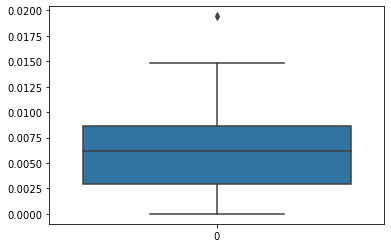

Authent Type
Batch                     539
CachedInteractive         109
InteractiveLogon         1151
NetworkLogon            12220
RemoteInteractive         342
ScreensaverDismissed      443
ScreensaverInvoked        426
Service                  1128
TGS                     17212
TGT                      4838
WorkstationLock          1100
WorkstationUnlock        1346
dtype: int64


In [29]:
simple_ae_eval(anomaly_bool_5,anomalies_ae_5,val_loss_5,set(rt_usernames),'red team')

In [30]:
try:
    print('Reading Data.')
    anomalies_ae_n_5 = pickle.load(open('Non RT Anomalies.p','rb'))
    val_loss_n_5 = pickle.load(open('Non RT VL.p','rb'))
    anomaly_bool_N_5 = []
    anomalies_ae_n_5 = anomalies_ae_n_5.drop_duplicates()

    for un in non_rt_sample:
        try:
            anomaly_bool_N_5.append((len(anomalies_ae_n_5[anomalies_ae_n_5['UserName'] == un]),un))
        except KeyError:
            anomaly_bool_N_5.append((0,un))
    clear_output()
    print('Data available.')
except:
    clear_output()
    print('Running AutoEncoder')
    frames_n_5 = []
    anomaly_bool_N_5 = []
    val_loss_n_5 = []
    bound = 400

    s_time = datetime.datetime.now()

    for i,un in enumerate(non_rt_sample):
        f,b,val = ae_anomaly_finder(un,24)
        if b == 1:
            frames_n_5.append(f)
            anomaly_bool_N_5.append((len(f),un))
            val_loss_n_5.append((val,un))
        else:
            anomaly_bool_N_5.append((0,un))
            val_loss_n_5.append((val,un))
            pass
    anomalies_ae_n_5 = pd.concat(frames_n_5)
    pickle.dump(anomalies_ae_n_5,open('Non RT Anomalies.p','wb'))
    pickle.dump(val_loss_n_5,open('Non RT VL.p','wb'))
    pickle.dump(non_rt_sample,open('Random Sample of Non Red Team Usernames.p','wb'))
    e_time = datetime.datetime.now()
    print(e_time-s_time)

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Restoring model weights from the end of the best epoch.
Epoch 00029: early stopping
0:56:23.922771


174 of the normal usernames were identified to have anomalies out of 200 normal usernames. The folloiwng usernames were found to have no anomalies
--------------------------------------------------------------------------------------------
User401689, Comp362353$, Comp393779$, Comp421434$, User319750, Comp740988$, Comp674474$, Comp089988$, User108742, Comp388786$, User184125, Comp498283$, Comp682953$, User324397, Comp985400$, User392061, User319181, User924320, User140503, Comp722112$, User569089, User739034, User494395, User793668, Comp288826$, Comp120148$
25.73% of the normal data was identified as anomalous.


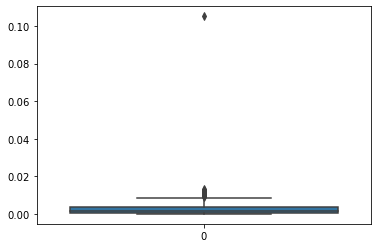

Authent Type
CachedInteractive          30
InteractiveLogon          422
NetworkLogon             7108
RemoteInteractive          68
ScreensaverDismissed      206
ScreensaverInvoked        200
Service                     2
TGS                     11820
TGT                      3091
WorkstationLock           560
WorkstationUnlock         741
dtype: int64


In [31]:
simple_ae_eval(anomaly_bool_N_5,anomalies_ae_n_5,val_loss_n_5,non_rt_sample,'normal')

In [60]:
MCC(84,26,174,11)

(array([37.28813559, 32.55813953, 88.42105263, 87.        ]),
 0.02004823981500066)

#### Poisson AD

Here we run a Poisson anomaly detection algorithm.

Based on a gamma prior for a poisson distribution, we can estimate $ \lambda $ by $ \frac{(\sum{x_{i}} + \alpha)}{(n + \beta)}$. This is because under a $\Gamma(\alpha,\beta)$ prior for $\lambda$ we have that the posterior is $$ \pi(\lambda|x) \propto \lambda^{\sum{x_{i}}+\alpha-1} e^{-(n+\beta)\lambda}$$

This allows us to find anomalies based on the output of our poisson model.

In [32]:
def poiss_orig_finder(user,n,idx):
    
    j_idx = idx % n
    i_idx = int(idx/n)

    chunks = split_dataframe(authentication_data[auth_start_days[i_idx]:auth_start_days[i_idx+1]],n)
    data = chunks[j_idx][chunks[j_idx]['UserName'] == user]
    
    return data

Here we define the Poisson anomaly detection model. We define the model with both the possibility to combine and not combine here.

In [33]:
def poiss_ae_detection(usernames,n,comb,alpha=1,beta=1):
    events_frames = []
    
    for (un_ct,un) in tqdm(enumerate(usernames)):

        pois_df = auth_type_un_df(un,n)
        bayes_mean = []
        bayes_var = []
        alpha = alpha
        beta = beta

        f_probs = []

        for col in pois_df.columns:
            dt = pois_df.iloc[:57*n][col]
            bayes_mean.append((alpha+sum(dt))/(beta+len(dt)))
            bayes_var.append((alpha+sum(dt))/(beta+len(dt))**2)

        probabilities = stats.poisson.pmf(pois_df.iloc[57*n:82*n],bayes_mean)
        
        if comb == True:
            for i in range(len(probabilities)):

                prob = probabilities[i]

                f_probs.append(stats.combine_pvalues(prob))
            for i in range(len(f_probs)):

                pv = f_probs[i][1]

                if pv <= 0.05:
                    events_frames.append(poiss_orig_finder(un,n,57*n+i))
        
        elif comb == False:
            for i in range(len(probabilities)):
                
                prob = probabilities[i]
                
                if any(prob <= 0.05):
                    events_frames.append(poiss_orig_finder(un,n,57*n+i))
        
    events = pd.concat(events_frames)
    return events

Here we define our analysis for the poisson anomaly detection model.

In [34]:
def simple_poiss_eval(anomaly_bools,anomalies,usernames,type_un):
    
    non_anom = []
    for i in range(len(anomaly_bools)):
        if anomaly_bools[i][0] == 0:    
            non_anom.append(anomaly_bools[i][1])

    anom = []
    for i in range(len(anomaly_bools)):
        if anomaly_bools[i][0] != 0:    
            anom.append(anomaly_bools[i][1])
    
    print('{} of the {} usernames were identified to have anomalies out of {} {} usernames. The folloiwng usernames were found to have no anomalies'.
          format(len(np.where(np.array([i[0] for i in anomaly_bools]) > 0)[0]),type_un,len(anomaly_bools),type_un))
    print('--------------------------------------------------------------------------------------------')        
    print(', '.join(map(str,non_anom)))
    
    perc = 100*len(anomalies)/len(authentication_data[authentication_data['UserName'].isin(usernames)])
    print('{:.2f}% of the {} data was identified as anomalous.'.format(perc,type_un))
    
    print(anomalies.groupby('Authent Type').size())
    
    anomalies.head()
    
    return

This block of code runs and analyses the models predictions on the red team data when combining results using Fisher's method.

In [35]:
s_time = datetime.datetime.now()
poisson_anoms = poiss_ae_detection(list(set(rt_usernames)),24,True)

poisson_anoms = poisson_anoms.drop_duplicates()
poiss_anom_bool = []

for un in rt_usernames:
    if un in list(poisson_anoms['UserName']):
        poiss_anom_bool.append((1,un))
    else:
        poiss_anom_bool.append((0,un))
e_time = datetime.datetime.now()
print(e_time-s_time)
simple_poiss_eval(poiss_anom_bool,poisson_anoms,list(set(rt_usernames)),'red team')

0it [00:00, ?it/s]

C:\Users\corri\anaconda3\lib\site-packages\scipy\stats\stats.py:7661: RuntimeWarning: divide by zero encountered in log
  statistic = -2 * np.sum(np.log(pvalues))


0:07:08.003718
90 of the red team usernames were identified to have anomalies out of 99 red team usernames. The folloiwng usernames were found to have no anomalies
--------------------------------------------------------------------------------------------
User133028, User702833, User859748, User457932, User829941, User405399, User900703, User497510, User222822
14.71% of the red team data was identified as anomalous.
Authent Type
Batch                    199
CachedInteractive        101
InteractiveLogon         647
NetworkLogon            8717
RemoteInteractive        232
ScreensaverDismissed     199
ScreensaverInvoked       196
Service                  453
TGS                     7817
TGT                     2416
WorkstationLock          538
WorkstationUnlock        815
dtype: int64


This block of code runs and analyses the poisson model on the red team data when not combining.

In [36]:
s_time = datetime.datetime.now()
poisson_anoms_nc = poiss_ae_detection(rt_usernames,24,False)

poisson_anoms_nc = poisson_anoms_nc.drop_duplicates()
poiss_anom_bool_nc = []

for un in rt_usernames:
    if un in list(poisson_anoms_nc['UserName']):
        poiss_anom_bool_nc.append((1,un))
    else:
        poiss_anom_bool_nc.append((0,un))
e_time = datetime.datetime.now()
print(e_time-s_time)
simple_poiss_eval(poiss_anom_bool_nc,poisson_anoms_nc,rt_usernames,'red team')

0it [00:00, ?it/s]

0:07:40.670578
98 of the red team usernames were identified to have anomalies out of 99 red team usernames. The folloiwng usernames were found to have no anomalies
--------------------------------------------------------------------------------------------
User405399
16.96% of the red team data was identified as anomalous.
Authent Type
Batch                     200
CachedInteractive         133
InteractiveLogon          733
NetworkLogon            10545
RemoteInteractive         264
ScreensaverDismissed      210
ScreensaverInvoked        207
Service                   454
TGS                      9000
TGT                      2560
WorkstationLock           569
WorkstationUnlock         873
dtype: int64


This block of code runs and analyses the poisson model for the non red team username sample when not combining.

In [37]:
s_time = datetime.datetime.now()

poisson_anoms_n = poiss_ae_detection(non_rt_sample,24,False)

poisson_anoms_n = poisson_anoms_n.drop_duplicates()
poiss_anom_bool_n = []

for un in non_rt_sample:
    if un in list(poisson_anoms_n['UserName']):
        poiss_anom_bool_n.append((1,un))
    else:  
        poiss_anom_bool_n.append((0,un))
e_time = datetime.datetime.now()
print(e_time-s_time)
simple_poiss_eval(poiss_anom_bool_n,poisson_anoms_n,non_rt_sample,'normal')

0it [00:00, ?it/s]

0:15:08.324453
179 of the normal usernames were identified to have anomalies out of 200 normal usernames. The folloiwng usernames were found to have no anomalies
--------------------------------------------------------------------------------------------
Comp792408$, Comp166939$, User835130, Comp982997$, Comp220136$, User034060, Comp421434$, User681533, User658064, User108742, Comp282554$, Comp556020$, Comp834308$, Comp682953$, Comp156369$, User611055, User248771, User924320, Comp722112$, Comp360389$, Comp855953$
15.10% of the normal data was identified as anomalous.
Authent Type
CachedInteractive         14
InteractiveLogon         211
NetworkLogon            5677
RemoteInteractive         29
ScreensaverDismissed     103
ScreensaverInvoked       100
Service                    3
TGS                     5889
TGT                     1388
WorkstationLock          309
WorkstationUnlock        503
dtype: int64


In [63]:
MCC(94,21,179,1)

(array([38.98305085, 34.43223443, 98.94736842, 89.5       ]),
 0.16803315759376639)

#### Inhomogenous Poisson AD

Here we define our 'inhomohenous' poisson model. For each day we calculate an independent poisson $ \lambda $.

In [38]:
def inhom_poiss_ae_detection_2(usernames,n,comb,alpha=1,beta=1):
    events_frames = []
    
    for (un_ct,un) in enumerate(usernames):
        
        clear_output(wait=True)
        print('Working with username {} of {}. {:.2f} percentage complete.'.format(un_ct+1,len(usernames),100*((un_ct+1)/len(usernames))))
        pois_df = auth_type_un_df(un,n)
        bayes_mean = []
        bayes_var = []
        alpha = alpha
        beta = beta

        f_probs = []

        for i in range(n):
            bayes_mean_hr = []
            bayes_var_hr = []
            for col in pois_df.columns:
                dt = list(pd.concat([pois_df.iloc[:57*n],pois_df.iloc[83*n:]])[col])
                dt_hspl = dt[i::n]
                bayes_mean_hr.append((alpha+sum(dt_hspl))/(beta+len(dt_hspl)))
                bayes_var_hr.append((alpha+sum(dt_hspl))/(beta+len(dt_hspl))**2)

            bayes_mean.append(bayes_mean_hr)
            bayes_var.append(bayes_var_hr)
        
        find_prob = []
        for i in range(n):
            find_prob.append(pd.DataFrame(stats.poisson.pmf(pd.concat([pois_df.iloc[:57*n], pois_df.iloc[83*n:]]).iloc[i::n],bayes_mean[i])).min())
                
        probabilities = []
        
        for i in range(n):

            probabilities.append(stats.poisson.pmf(pois_df.iloc[57*n:82*n].iloc[i::n],bayes_mean[i]))

        for i in range(n):

            probs = probabilities[i]

            for j in range(len(probs)):

                hr_prob = probs[j]
                
                thresh = find_prob[i]
                
                if [item1 for item1,item2 in zip(hr_prob,thresh) if item1 <= item2] != []:

                    events_frames.append(poiss_orig_finder(un,n,57*n+j*n+i))

    events = pd.concat(events_frames)
    
    return events

Here we run our inhomogenous poisson model on the red team data.

In [39]:
s_time = datetime.datetime.now()
poisson_anoms_inhom = inhom_poiss_ae_detection_2(rt_usernames,24,False)

poisson_anoms_inhom = poisson_anoms_inhom.drop_duplicates()
poiss_anom_bool_inhom = []

for un in rt_usernames:
    if un in list(poisson_anoms_inhom['UserName']):
        poiss_anom_bool_inhom.append((1,un))
    else:
        poiss_anom_bool_inhom.append((0,un))
e_time = datetime.datetime.now()
print(e_time-s_time)
simple_poiss_eval(poiss_anom_bool_inhom,poisson_anoms_inhom,rt_usernames,'red team')

Working with username 99 of 99. 100.00 percentage complete.
0:08:33.230825
98 of the red team usernames were identified to have anomalies out of 99 red team usernames. The folloiwng usernames were found to have no anomalies
--------------------------------------------------------------------------------------------
User405399
17.21% of the red team data was identified as anomalous.
Authent Type
Batch                     200
CachedInteractive         143
InteractiveLogon          748
NetworkLogon            10842
RemoteInteractive         264
ScreensaverDismissed      211
ScreensaverInvoked        208
Service                   454
TGS                      9057
TGT                      2561
WorkstationLock           569
WorkstationUnlock         874
dtype: int64


Here we run our inhomogenous model on the non-red team data.

In [40]:
s_time = datetime.datetime.now()

inhom_poisson_anoms_n = inhom_poiss_ae_detection_2(non_rt_sample,24,False)

inhom_poisson_anoms_n = inhom_poisson_anoms_n.drop_duplicates()
inhom_poiss_anom_bool_n = []

for un in non_rt_sample:
    if un in list(inhom_poisson_anoms_n['UserName']):
        inhom_poiss_anom_bool_n.append((1,un))
    else:
        inhom_poiss_anom_bool_n.append((0,un))
e_time = datetime.datetime.now()
print(e_time-s_time)
simple_poiss_eval(inhom_poiss_anom_bool_n,inhom_poisson_anoms_n,non_rt_sample,'normal')

Working with username 200 of 200. 100.00 percentage complete.
0:17:05.820563
179 of the normal usernames were identified to have anomalies out of 200 normal usernames. The folloiwng usernames were found to have no anomalies
--------------------------------------------------------------------------------------------
Comp792408$, Comp166939$, User835130, Comp982997$, Comp220136$, User034060, Comp421434$, User681533, User658064, User108742, Comp282554$, Comp556020$, Comp834308$, Comp682953$, Comp156369$, User611055, User248771, User924320, Comp722112$, Comp360389$, Comp855953$
15.61% of the normal data was identified as anomalous.
Authent Type
CachedInteractive         14
InteractiveLogon         212
NetworkLogon            5990
RemoteInteractive         29
ScreensaverDismissed     103
ScreensaverInvoked       100
Service                    3
TGS                     6044
TGT                     1398
WorkstationLock          312
WorkstationUnlock        506
dtype: int64


In [64]:
MCC(94,21,179,1)

(array([38.98305085, 34.43223443, 98.94736842, 89.5       ]),
 0.16803315759376639)

#### Supervised Neural Network AD

Here we create our data for our supervised neural network data and turn the task of unsupervised anomaly detection into supervised anomaly detection.

In [66]:
username_sample = list(pd.Series(rt_usernames).unique()) + non_rt_sample
data = []
for user in tqdm(username_sample):
    if user in rt_usernames:
        anom = 1
    else:
        anom = 0
    df = feature_generation_supervised(user,24,anom)
    data.append(df)
nn_data = pd.concat(data)
nn_data.to_csv('nn_supervised data.gz', compression='gzip')
X_train, X_test, y_train, y_test = train_test_split(nn_data[['UserName','SrcUnique','DstUnique','Authentications','Failures']], nn_data['Anomaly'], test_size=0.1, random_state=42)
X_train_un_list = list(X_train['UserName'])
X_test_un_list = list(X_test['UserName'])
X_train = X_train.drop('UserName',axis=1)
X_test = X_test.drop('UserName',axis=1)

  0%|          | 0/295 [00:00<?, ?it/s]

In [67]:
def nn_anomaly_finder(x_train,x_test,y_train,y_test,train_user,test_user,n,BATCH_SIZE=256, EPOCHS=1000):
    
    # create our scaling pipeline
    pipeline = Pipeline([('normalizer', Normalizer()),
                    ('scaler', MinMaxScaler())])
    pipeline.fit(x_train)
    x_train = pipeline.transform(x_train)
    x_test = pipeline.transform(x_test)
    
    # define neural network parameters
    input_dim = x_train.shape[1]
    BATCH_SIZE = BATCH_SIZE
    EPOCHS = EPOCHS

    # define the nn
    neural_network =Sequential([

        tf.keras.layers.Dense(input_dim, activation='elu', input_shape=(input_dim, )),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(32, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(32, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(32, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(32, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(16, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(8, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(4, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(4, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(1, activation='sigmoid')

    ])

    # compile the autoencoder
    neural_network.compile(optimizer="adam", 
                        loss='binary_crossentropy',
                        metrics=["acc"])
    
    early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0.0001,
    patience=10,
    verbose=1, 
    mode='min',
    restore_best_weights=True
    )
    
    # allows for early stopping and better visualisation of progress
    cb = [early_stop,TqdmCallback(verbose=1)]
    
    # fit the auto encoder
    history = neural_network.fit(
        x_train, y_train,
        shuffle=True,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        validation_split=0.1,
        verbose=0,
        callbacks=cb   
    )
    
    # make predictions on the remaining data
    x_test_pred = neural_network.predict(x_test)
    Y_pred = x_test_pred.argmax(axis=1)
    test_loss, test_acc = neural_network.evaluate(X_test, y_test)
    print(test_acc)
    
    anomalies = x_test[np.where(x_test_pred == 1)]
    #anomaly_idx = anomalies[0]
    
    #frame = []
    #for i in range(len(anomaly_idx)):
    #    user = test_user[anomaly_idx[i]]
    #    anomaly = nn_orig_finder(user,n,anomaly_idx[i])
        
        # indicates that an anomaly was found where we have no information i.e. the lack of an event was anomalous
    #    if len(anomaly) == 0:
    #        pass
    #    else:
    #        frame.append(anomaly)
    #    
    #if len(frame) != 0:
    #    anomaly_df = pd.concat(frame)
    #    return anomaly_df,1,history.history["val_loss"]
    #else:
    #    print('No anomalies found.')
    #    return pd.DataFrame(test_mae_loss).describe(),0,history.history["val_loss"]
    return Y_pred

In [68]:
Y_pred = nn_anomaly_finder(X_train,X_test,y_train,y_test,X_train_un_list,X_test_un_list,24,BATCH_SIZE=256, EPOCHS=1000)

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Restoring model weights from the end of the best epoch.
Epoch 00035: early stopping
1992/1992 [==============================] - 1s 562us/step - loss: 0.3059 - acc: 0.9080
0.908019483089447


In [69]:
def classification_eval(y_pred,df_test_resp):
    dec = np.int64(np.ceil(np.log10(len(df_test_resp))))
    
    print("Confusion Matrix")
    print(confusion_matrix(df_test_resp,y_pred),'\n')
    
    print('Classification report')
    print(classification_report(df_test_resp, y_pred, digits=dec))
    
    print("Scalar Metrics")
    format_str = '%%13s = %%.%if' % dec
    print(format_str % ('MCC', matthews_corrcoef(df_test_resp, y_pred)))
    print(format_str % ("Cohen's kappa", cohen_kappa_score(df_test_resp, y_pred)))
    print(format_str % ('Accuracy', accuracy_score(df_test_resp, y_pred)))

In [70]:
classification_eval(Y_pred,y_test)

Confusion Matrix
[[57862     0]
 [ 5858     0]] 

Classification report
              precision    recall  f1-score   support

           0    0.90807   1.00000   0.95182     57862
           1    0.00000   0.00000   0.00000      5858

    accuracy                        0.90807     63720
   macro avg    0.45403   0.50000   0.47591     63720
weighted avg    0.82458   0.90807   0.86431     63720

Scalar Metrics
          MCC = 0.00000
Cohen's kappa = 0.00000
     Accuracy = 0.90807


C:\Users\corri\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\corri\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\corri\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\corri\anaconda3\lib\site-packages\sklearn\metr

#### ASE AD

For this we need to know which data is red team and which is normal, we do this here.

In [71]:
a = []
for i in columns_sparse:
    b = i in list(rt_usernames)
    a.append(b)
idx = [i for i,x in enumerate(a) if x == True]

Here we implement the ASE function based on - https://arxiv.org/pdf/2008.10055.pdf, https://jscholarship.library.jhu.edu/bitstream/handle/1774.2/37075/SUSSMAN-DISSERTATION-2014.pdf

In [72]:
def ASE_anom_finder(window_length):

    vertex_norm_tracker = []
    graph_norm_tracker = []

    graph_mam_tracker = []
    graph_range_tracker = []

    vertex_mam_tracker = []
    vertex_range_tracker = []

    for t in tqdm(range(len(data_frame_list_uase)-1)):
        u1, s1, v1 = scipy.sparse.linalg.svds(data_frame_list_uase[t],k=7)
        u2, s2, v2 = scipy.sparse.linalg.svds(data_frame_list_uase[t+1],k=7)
        Y1 = pd.DataFrame((v1.transpose()*s1**0.5).transpose(),columns=(list(set(columns_sparse))))
        Y2 = pd.DataFrame((v2.transpose()*s2**0.5).transpose(),columns=(list(set(columns_sparse))))

        nrm = scipy.linalg.norm(Y2-Y1,ord=2)
        graph_norm_tracker.append(nrm)

        vertex_norms = []
        for v in list(columns_sparse):
            nrm = scipy.linalg.norm(Y2[v]-Y1[v],ord=2)
            vertex_norms.append(nrm)

        vertex_norm_tracker.append(vertex_norms)

        if t >= window_length:
            graph_mam = np.sum(graph_norm_tracker[(t-window_length+1):t-1])/(window_length-1)
            graph_range = np.sum(np.linalg.norm(np.array(graph_norm_tracker[t-window_length+2:t-1])-np.array(graph_norm_tracker[t-window_length+1:t-2])))/(1.128*(window_length-2))
            graph_mam_tracker.append(graph_mam)
            graph_range_tracker.append(graph_range)

            vertex_mam_tracker_day = []
            vertex_range_tracker_day = []

            for j in range(len(list(columns_sparse))):
                vertex_mam = np.sum([vertex_norm_tracker[k][j] for k in range(t-window_length+1,t)])/(window_length-1)
                vertex_mam_tracker_day.append(vertex_mam)
                vertex_range = np.sqrt((vertex_mam*(1-vertex_mam))/(window_length-1))
                #vertex_range = np.std([vertex_norm_tracker[k][j] for k in range(t-window_length+1,t)])/(window_length-1)
                vertex_range_tracker_day.append(vertex_range)
            vertex_mam_tracker.append(vertex_mam_tracker_day)
            vertex_range_tracker.append(vertex_range_tracker_day)

    day_anomalies = []

    for i,v in enumerate(list(columns_sparse)):
        y_v = np.array([vertex_norm_tracker[k][i] for k in range(len(vertex_norm_tracker))])
        ucl_v = np.array([vertex_mam_tracker[k][i] for k in range(len(vertex_mam_tracker))])+3*np.array([vertex_range_tracker[k][i] for k in range(len(vertex_range_tracker))])
        anomalies = [j+window_length+1 for j,y in enumerate(y_v[window_length:]) if y > ucl_v[j]]
        if len(anomalies) > 0:
            day_anomalies.append((v,anomalies))
        
    return vertex_norm_tracker, graph_norm_tracker, graph_mam_tracker, graph_range_tracker, vertex_mam_tracker, vertex_range_tracker, day_anomalies

We call our function for sliding windows of lengths: 14, 7, 5, 3, 2.

In [73]:
vertex_norm_tracker_14, graph_norm_tracker_14, graph_mam_tracker_14, graph_range_tracker_14, vertex_mam_tracker_14, vertex_range_tracker_14, day_anomalies_14 = ASE_anom_finder(14)
vertex_norm_tracker_7, graph_norm_tracker_7, graph_mam_tracker_7, graph_range_tracker_7, vertex_mam_tracker_7, vertex_range_tracker_7, day_anomalies_7 = ASE_anom_finder(7)
vertex_norm_tracker_5, graph_norm_tracker_5, graph_mam_tracker_5, graph_range_tracker_5, vertex_mam_tracker_5, vertex_range_tracker_5, day_anomalies_5 = ASE_anom_finder(5)
vertex_norm_tracker_3, graph_norm_tracker_3, graph_mam_tracker_3, graph_range_tracker_3, vertex_mam_tracker_3, vertex_range_tracker_3, day_anomalies_3 = ASE_anom_finder(3)
vertex_norm_tracker_2, graph_norm_tracker_2, graph_mam_tracker_2, graph_range_tracker_2, vertex_mam_tracker_2, vertex_range_tracker_2, day_anomalies_2 = ASE_anom_finder(2)

  0%|          | 0/89 [00:00<?, ?it/s]

<ipython-input-72-f4939e4061e8>:40: RuntimeWarning: invalid value encountered in sqrt
  vertex_range = np.sqrt((vertex_mam*(1-vertex_mam))/(window_length-1))


  0%|          | 0/89 [00:00<?, ?it/s]

  0%|          | 0/89 [00:00<?, ?it/s]

  0%|          | 0/89 [00:00<?, ?it/s]

  0%|          | 0/89 [00:00<?, ?it/s]

<ipython-input-72-f4939e4061e8>:30: RuntimeWarning: invalid value encountered in double_scalars
  graph_range = np.sum(np.linalg.norm(np.array(graph_norm_tracker[t-window_length+2:t-1])-np.array(graph_norm_tracker[t-window_length+1:t-2])))/(1.128*(window_length-2))


This is a quick look at how many anomalies we detect (how many usernames have anomalies).

We also produce plots of the data here.

In [74]:
def plot_creation(window_length,vertex_mam_tracker,vertex_range_tracker,vertex_norm_tracker,u):
    
    plt.figure(figsize = (16,8))  
    plt.plot(np.arange(window_length,len(data_frame_list_uase)-1),[vertex_mam_tracker[k][u] for k in range(len(vertex_mam_tracker))])
    plt.plot(np.arange(window_length,len(data_frame_list_uase)-1),np.array([vertex_mam_tracker[k][u] for k in range(len(vertex_mam_tracker))])+3*np.array([vertex_range_tracker[k][u] for k in range(len(vertex_range_tracker))]),'--')
    plt.plot([vertex_norm_tracker[k][u] for k in range(len(vertex_norm_tracker))],'r.')
    plt.xlabel('Day')
    plt.ylabel('$||{X_{i}^{(t+1)}-X_{i}^{(t)}}||$')
    plt.title('Window Length: {}'.format(window_length))
    plt.show()
    
    return

The below code plots this for the entire graph.

In [75]:
def graph_plot_creation(window_length,graph_mam_tracker,graph_range_tracker,graph_norm_tracker):
    
    plt.figure(figsize=(16,8))
    plt.plot(np.arange(window_length,len(graph_mam_tracker)+window_length),graph_mam_tracker)
    plt.plot(np.arange(window_length,len(graph_mam_tracker)+window_length),np.array(graph_mam_tracker) + 3 * np.array(graph_range_tracker))
    plt.plot(graph_norm_tracker,'r.')
    plt.xlabel('Day')
    plt.ylabel('$||X^{(t+1)}-X^{(t)}||$')
    plt.title('Window Length: {}'.format(window_length))
    plt.show()
    
    return

We now plot the entire graph results.

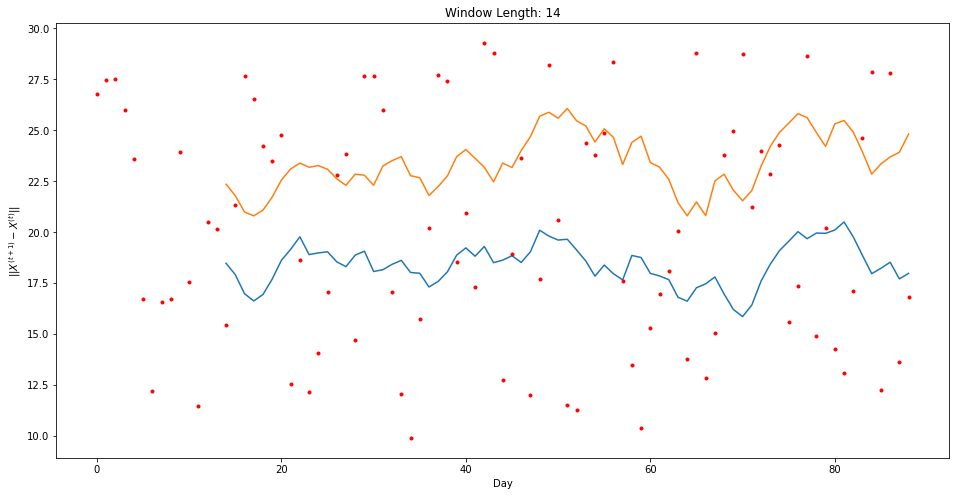

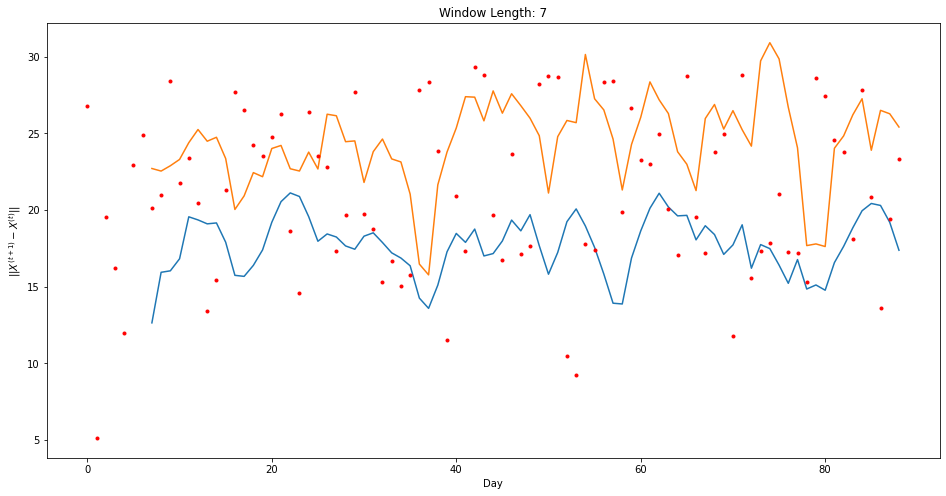

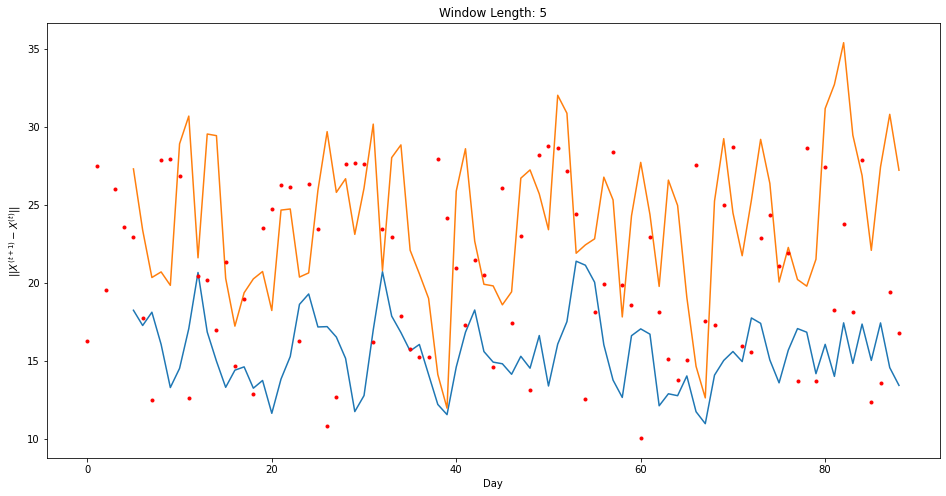

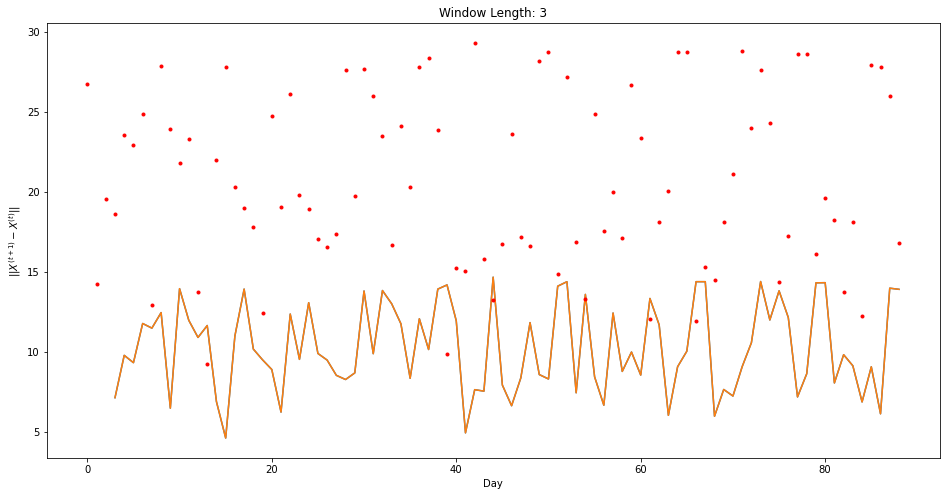

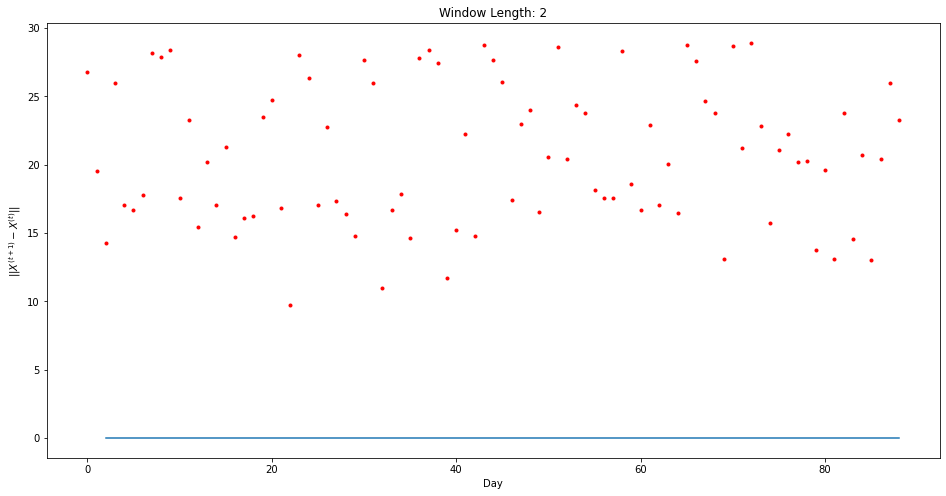

In [76]:
graph_plot_creation(14,graph_mam_tracker_14,graph_range_tracker_14,graph_norm_tracker_14)
graph_plot_creation(7,graph_mam_tracker_7,graph_range_tracker_7,graph_norm_tracker_7)
graph_plot_creation(5,graph_mam_tracker_5,graph_range_tracker_5,graph_norm_tracker_5)
graph_plot_creation(3,graph_mam_tracker_3,graph_range_tracker_3,graph_norm_tracker_3)
graph_plot_creation(2,graph_mam_tracker_2,graph_range_tracker_2,graph_norm_tracker_2)

The below code finds a red team user and plots it.

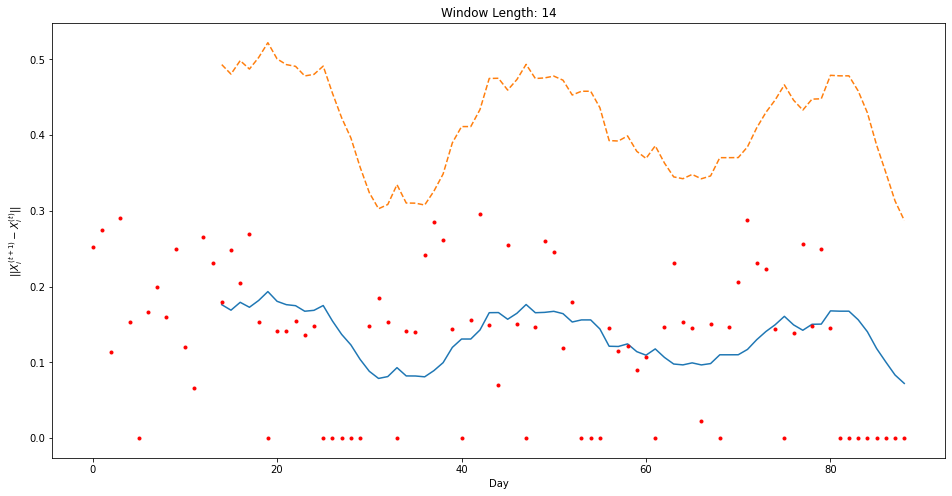

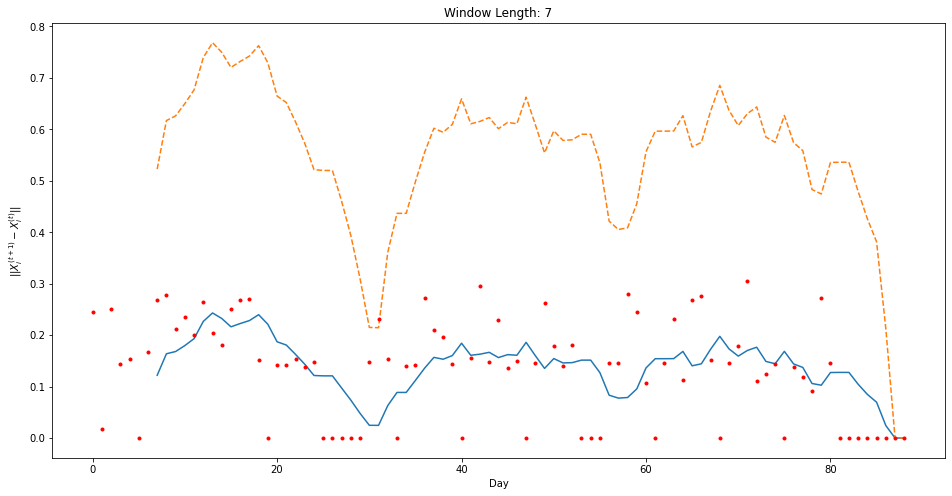

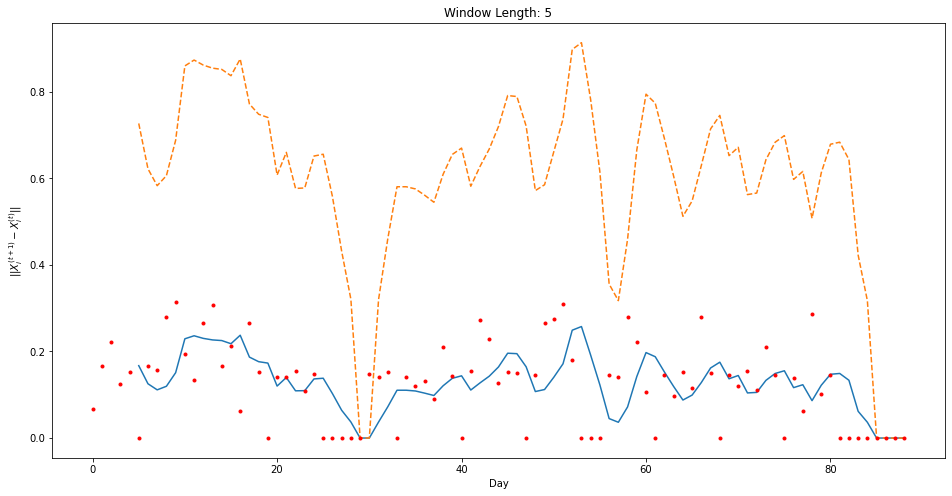

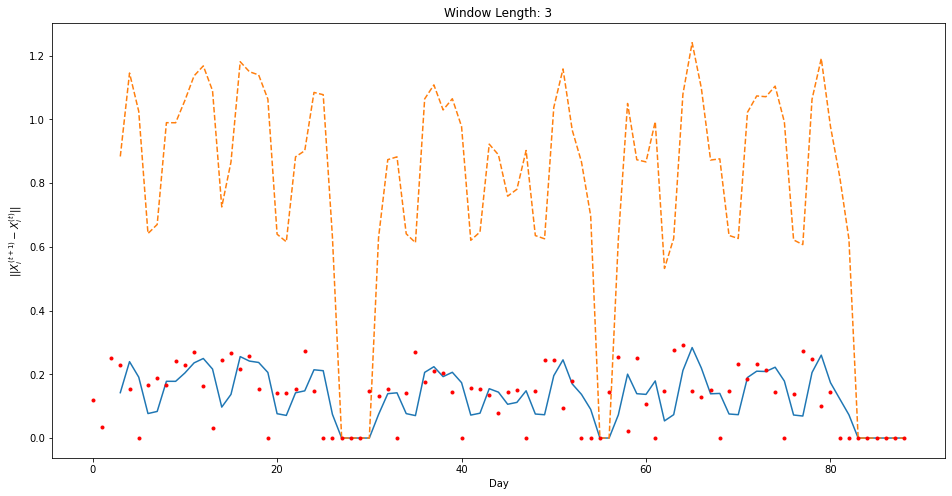

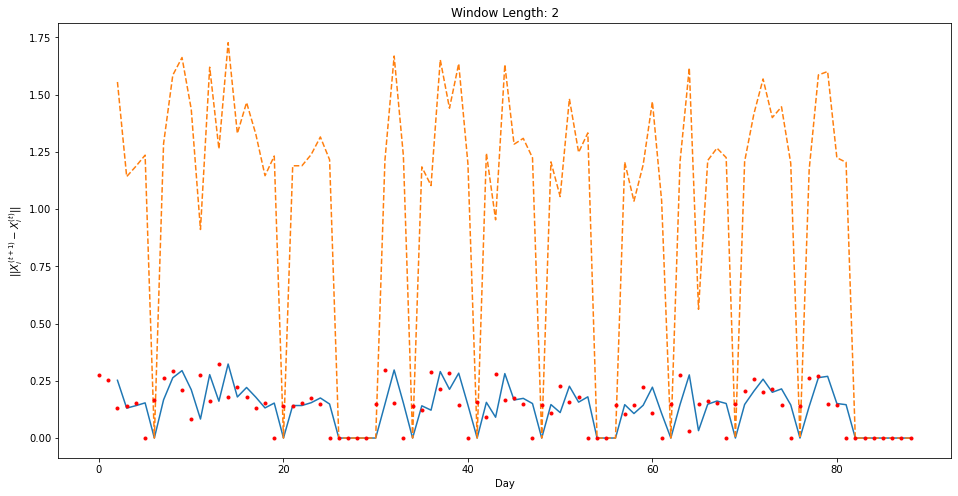

In [77]:
rt_user_idx = []
for i,un in enumerate(columns_sparse):
    b = un in list(rt_usernames)
    if b == True:
        rt_user_idx.append(i)

plot_creation(14,vertex_mam_tracker_14,vertex_range_tracker_14,vertex_norm_tracker_14,rt_user_idx[0])
plot_creation(7,vertex_mam_tracker_7,vertex_range_tracker_7,vertex_norm_tracker_7,rt_user_idx[0])
plot_creation(5,vertex_mam_tracker_5,vertex_range_tracker_5,vertex_norm_tracker_5,rt_user_idx[0])
plot_creation(3,vertex_mam_tracker_3,vertex_range_tracker_3,vertex_norm_tracker_3,rt_user_idx[0])
plot_creation(2,vertex_mam_tracker_2,vertex_range_tracker_2,vertex_norm_tracker_2,rt_user_idx[0])

In [78]:
def anomaly_count_rt(day_anomalies,day):
    anomaly_users = []
    for i in range(len(day_anomalies)):
        anomaly_users.append(day_anomalies[i][0])

    rt_ct = 0
    for un in set(rt_usernames):
        if un in anomaly_users:
            rt_ct += 1
            
    n_ct = 0
    for un in set(rt_usernames) ^ set(list(columns_sparse)):
        if un in anomaly_users:
            n_ct += 1
    
    print('Using a sliding window of length {} captures {}% of rt users as anomalous and {}% of normal users as anomalous.'.format(day,rt_ct/len(set(rt_usernames)),(n_ct/len(set(rt_usernames) ^ set(list(columns_sparse))))))
    print('Using a sliding window of length {} captures {} of {} rt users as anomalous and {} of {} normal users as anomalous.'.format(day,rt_ct,len(set(rt_usernames)),n_ct,len(set(rt_usernames) ^ set(list(columns_sparse)))))
    
    return

In [79]:
anomaly_count_rt(day_anomalies_14,14)
anomaly_count_rt(day_anomalies_7,7)
anomaly_count_rt(day_anomalies_5,5)
anomaly_count_rt(day_anomalies_3,3)
anomaly_count_rt(day_anomalies_2,2)

Using a sliding window of length 14 captures 0.3368421052631579% of rt users as anomalous and 0.38628133704735373% of normal users as anomalous.
Using a sliding window of length 14 captures 32 of 95 rt users as anomalous and 11094 of 28720 normal users as anomalous.
Using a sliding window of length 7 captures 0.4% of rt users as anomalous and 0.43057103064066854% of normal users as anomalous.
Using a sliding window of length 7 captures 38 of 95 rt users as anomalous and 12366 of 28720 normal users as anomalous.
Using a sliding window of length 5 captures 0.49473684210526314% of rt users as anomalous and 0.4931058495821727% of normal users as anomalous.
Using a sliding window of length 5 captures 47 of 95 rt users as anomalous and 14162 of 28720 normal users as anomalous.
Using a sliding window of length 3 captures 0.6210526315789474% of rt users as anomalous and 0.6680710306406685% of normal users as anomalous.
Using a sliding window of length 3 captures 59 of 95 rt users as anomalous 

In [80]:
print(MCC(42,28720-16859,16859,53))
print(MCC(61,28720-20868,20868,34))
print(MCC(65,28720-23840,23840,30))
print(MCC(93,28720-28240,28240,2))
print(MCC(95,28720-28567,28567,0))

(array([41.30834635,  0.24850601, 44.21052632, 58.70125348]), -0.016867829449985956)
(array([27.46139164,  0.29146161, 64.21052632, 72.66016713]), -0.0108639971506521)
(array([17.16120076,  0.27190964, 68.42105263, 83.00835655]), -0.022240468503002247)
(array([ 1.98854763,  0.32823916, 97.89473684, 98.32869081]), -0.0019396701483567773)
(array([  0.86066285,   0.33144931, 100.        ,  99.46727019]), 0.004202058114758256)


We re-run this, using a mean and range defined by the period we know to be normal i.e. the first 56 days.

In [81]:
def ASE_anom_finder_normal(window_length=56):

    vertex_norm_tracker = []
    graph_norm_tracker = []

    graph_mam_tracker = []
    graph_range_tracker = []

    vertex_mam_tracker = []
    vertex_range_tracker = []

    for t in tqdm(range(len(data_frame_list_uase)-1)):
        u1, s1, v1 = scipy.sparse.linalg.svds(data_frame_list_uase[t],k=7)
        u2, s2, v2 = scipy.sparse.linalg.svds(data_frame_list_uase[t+1],k=7)
        Y1 = pd.DataFrame((v1.transpose()*s1**0.5).transpose(),columns=(list(set(columns_sparse))))
        Y2 = pd.DataFrame((v2.transpose()*s2**0.5).transpose(),columns=(list(set(columns_sparse))))

        nrm = scipy.linalg.norm(Y2-Y1,ord=2)
        graph_norm_tracker.append(nrm)

        vertex_norms = []
        for v in list(columns_sparse):
            nrm = scipy.linalg.norm(Y2[v]-Y1[v],ord=2)
            vertex_norms.append(nrm)

        vertex_norm_tracker.append(vertex_norms)

        if t == window_length:
            graph_mam = np.sum(graph_norm_tracker[(t-window_length+1):t-1])/(window_length-1)
            graph_range = np.sum(np.linalg.norm(np.array(graph_norm_tracker[t-window_length+2:t-1])-np.array(graph_norm_tracker[t-window_length+1:t-2])))/(1.128*(window_length-2))
            graph_mam_tracker.append(graph_mam)
            graph_range_tracker.append(graph_range)

            vertex_mam_tracker_day = []
            vertex_range_tracker_day = []

            for j in range(len(list(columns_sparse))):
                vertex_mam = np.sum([vertex_norm_tracker[k][j] for k in range(t-window_length+1,t)])/(window_length-1)
                vertex_mam_tracker_day.append(vertex_mam)
                vertex_range = np.sqrt((vertex_mam*(1-vertex_mam))/(window_length-1))
                vertex_range_tracker_day.append(vertex_range)
            vertex_mam_tracker.append(vertex_mam_tracker_day)
            vertex_range_tracker.append(vertex_range_tracker_day)
        elif t > window_length:
            graph_mam_tracker.append(graph_mam_tracker[0])
            graph_range_tracker.append(graph_range_tracker[0])
            vertex_mam_tracker.append(vertex_mam_tracker[0])
            vertex_range_tracker.append(vertex_range_tracker[0])
    day_anomalies = []

    for i,v in enumerate(list(columns_sparse)):
        y_v = np.array([vertex_norm_tracker[k][i] for k in range(len(vertex_norm_tracker))])
        ucl_v = np.array([vertex_mam_tracker[k][i] for k in range(len(vertex_mam_tracker))])+3*np.array([vertex_range_tracker[k][i] for k in range(len(vertex_range_tracker))])
        anomalies = [j+window_length+1 for j,y in enumerate(y_v[window_length:]) if y > ucl_v[j]]
        if len(anomalies) > 0:
            day_anomalies.append((v,anomalies))
        
    return vertex_norm_tracker, graph_norm_tracker, graph_mam_tracker, graph_range_tracker, vertex_mam_tracker, vertex_range_tracker, day_anomalies

In [82]:
vertex_norm_tracker_normal, graph_norm_tracker_normal, graph_mam_tracker_normal, graph_range_tracker_normal, vertex_mam_tracker_normal, vertex_range_tracker_normal, day_anomalies_normal = ASE_anom_finder_normal()

  0%|          | 0/89 [00:00<?, ?it/s]

<ipython-input-81-87c9bcc8c996>:40: RuntimeWarning: invalid value encountered in sqrt
  vertex_range = np.sqrt((vertex_mam*(1-vertex_mam))/(window_length-1))


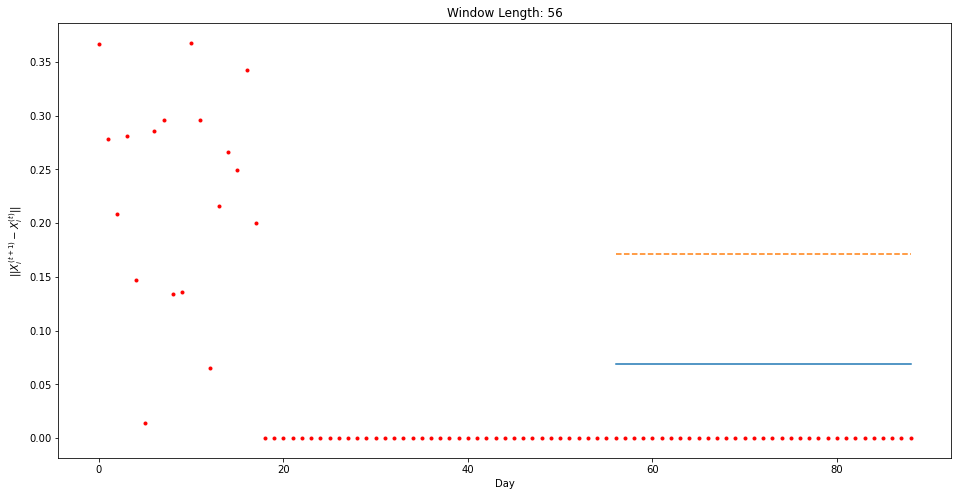

In [83]:
plot_creation(56,vertex_mam_tracker_normal,vertex_range_tracker_normal,vertex_norm_tracker_normal,23991)

In [84]:
anomaly_count_rt(day_anomalies_normal,56)

Using a sliding window of length 56 captures 0.42105263157894735% of rt users as anomalous and 0.4845055710306407% of normal users as anomalous.
Using a sliding window of length 56 captures 40 of 95 rt users as anomalous and 13915 of 28720 normal users as anomalous.


In [85]:
print(MCC(45,28720-13720,13720,50))

(array([52.21238938,  0.32691609, 47.36842105, 47.77158774]), -0.0004626816832603691)


#### UASE Implementation

Finally, we implement the UASE technique for decomposition and re-do our graph analysis.

In [86]:
def UASE_anom_finder(window_length):

    vertex_norm_tracker = []
    graph_norm_tracker = []

    graph_mam_tracker = []
    graph_range_tracker = []

    vertex_mam_tracker = []
    vertex_range_tracker = []

    weeks = int(len(data_frame_list_uase)/window_length)
    Y_arrays = []

    for i in range(weeks):
        matrices = []
        for j in range(window_length):
            matrices.append(data_frame_list_uase[i*window_length+j])

        wl_matrix = scipy.sparse.hstack(matrices)

        u, s, v = scipy.sparse.linalg.svds(wl_matrix.asfptype(),k=7)

        for j in range(window_length):
            v_j = pd.DataFrame(v).iloc[: ,28815*j:28815*(j+1)]
            Y = pd.DataFrame((v_j.transpose()*s**0.5).transpose())
            Y_arrays.append(Y)

    for t in tqdm(range(len(Y_arrays)-1)):
        
        Y2 = Y_arrays[t+1]
        Y1 = Y_arrays[t]
        nrm = scipy.linalg.norm(np.subtract(Y2,Y1),ord=2)
        graph_norm_tracker.append(nrm)

        vertex_norms = []
        
        for i,v in enumerate(list(columns_sparse)):
            nrm = scipy.linalg.norm(np.subtract(Y2.iloc[:,i],Y1.iloc[:,i]),ord=2)
            vertex_norms.append(nrm)

        vertex_norm_tracker.append(vertex_norms)

        if t >= window_length:
            graph_mam = np.sum(graph_norm_tracker[(t-window_length+1):t-1])/(window_length-1)
            graph_range = np.sum(np.linalg.norm(np.array(graph_norm_tracker[t-window_length+2:t-1])-np.array(graph_norm_tracker[t-window_length+1:t-2])))/(1.128*(window_length-2))
            graph_mam_tracker.append(graph_mam)
            graph_range_tracker.append(graph_range)

            vertex_mam_tracker_day = []
            vertex_range_tracker_day = []

            for j in range(len(list(columns_sparse))):
                vertex_mam = np.sum([vertex_norm_tracker[k][j] for k in range(t-window_length+1,t)])/(window_length-1)
                vertex_mam_tracker_day.append(vertex_mam)
                vertex_range = np.sqrt((vertex_mam*(1-vertex_mam))/(window_length-1))
                vertex_range_tracker_day.append(vertex_range)
            vertex_mam_tracker.append(vertex_mam_tracker_day)
            vertex_range_tracker.append(vertex_range_tracker_day)

    day_anomalies = []

    for i,v in enumerate(list(columns_sparse)):
        y_v = np.array([vertex_norm_tracker[k][i] for k in range(len(vertex_norm_tracker))])
        ucl_v = np.array([vertex_mam_tracker[k][i] for k in range(len(vertex_mam_tracker))])+3*np.array([vertex_range_tracker[k][i] for k in range(len(vertex_range_tracker))])
        anomalies = [j+window_length+1 for j,y in enumerate(y_v[window_length:]) if y > ucl_v[j]]
        if len(anomalies) > 0:
            day_anomalies.append((v,anomalies))
        
    return vertex_norm_tracker, graph_norm_tracker, graph_mam_tracker, graph_range_tracker, vertex_mam_tracker, vertex_range_tracker, day_anomalies

In [87]:
vertex_norm_tracker_7, graph_norm_tracker_7, graph_mam_tracker_7, graph_range_tracker_7, vertex_mam_tracker_7, vertex_range_tracker_7, day_anomalies_7_U = UASE_anom_finder(7)
vertex_norm_tracker_14, graph_norm_tracker_14, graph_mam_tracker_14, graph_range_tracker_14, vertex_mam_tracker_14, vertex_range_tracker_14, day_anomalies_14_U = UASE_anom_finder(14)
vertex_norm_tracker_3, graph_norm_tracker_3, graph_mam_tracker_3, graph_range_tracker_3, vertex_mam_tracker_3, vertex_range_tracker_3, day_anomalies_3_U = UASE_anom_finder(3)
vertex_norm_tracker_2, graph_norm_tracker_2, graph_mam_tracker_2, graph_range_tracker_2, vertex_mam_tracker_2, vertex_range_tracker_2, day_anomalies_2_U = UASE_anom_finder(2)
vertex_norm_tracker_5, graph_norm_tracker_5, graph_mam_tracker_5, graph_range_tracker_5, vertex_mam_tracker_5, vertex_range_tracker_5, day_anomalies_5_U = UASE_anom_finder(5)

  0%|          | 0/83 [00:00<?, ?it/s]

<ipython-input-86-a2d49b8a1c71>:33: FutureWarning: Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Series will be aligned before applying the ufunc.
Convert one of the arguments to a NumPy array (eg 'ufunc(df1, np.asarray(df2)') to keep the current behaviour, or align manually (eg 'df1, df2 = df1.align(df2)') before passing to the ufunc to obtain the future behaviour and silence this warning.
  nrm = scipy.linalg.norm(np.subtract(Y2,Y1),ord=2)
<ipython-input-86-a2d49b8a1c71>:56: RuntimeWarning: invalid value encountered in sqrt
  vertex_range = np.sqrt((vertex_mam*(1-vertex_mam))/(window_length-1))


  0%|          | 0/83 [00:00<?, ?it/s]

  0%|          | 0/89 [00:00<?, ?it/s]

  0%|          | 0/89 [00:00<?, ?it/s]

<ipython-input-86-a2d49b8a1c71>:46: RuntimeWarning: invalid value encountered in double_scalars
  graph_range = np.sum(np.linalg.norm(np.array(graph_norm_tracker[t-window_length+2:t-1])-np.array(graph_norm_tracker[t-window_length+1:t-2])))/(1.128*(window_length-2))


  0%|          | 0/89 [00:00<?, ?it/s]

In [88]:
def plot_creation_UASE(window_length,vertex_mam_tracker,vertex_range_tracker,vertex_norm_tracker,u,vertex=True):

    plt.figure(figsize = (16,8))  
    plt.plot(np.arange(window_length,len(data_frame_list_uase)-1-(len(data_frame_list_uase)%window_length)),[vertex_mam_tracker[k][u] for k in range(len(vertex_mam_tracker))])
    plt.plot(np.arange(window_length,len(data_frame_list_uase)-1-(len(data_frame_list_uase)%window_length)),np.array([vertex_mam_tracker[k][u] for k in range(len(vertex_mam_tracker))])+3*np.array([vertex_range_tracker[k][u] for k in range(len(vertex_range_tracker))]),'--')
    plt.plot([vertex_norm_tracker[k][u] for k in range(len(vertex_norm_tracker))],'r.')
    plt.xlabel('Day')
    plt.ylabel('$||{X_{i}^{(t+1)}-X_{i}^{(t)}}||$')
    plt.title('Window Length: {}'.format(window_length))
    plt.show()
    

    return

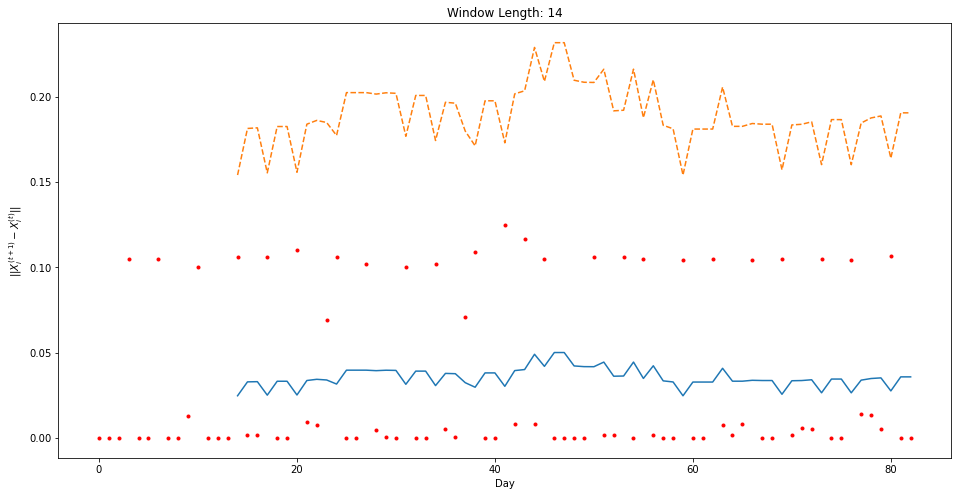

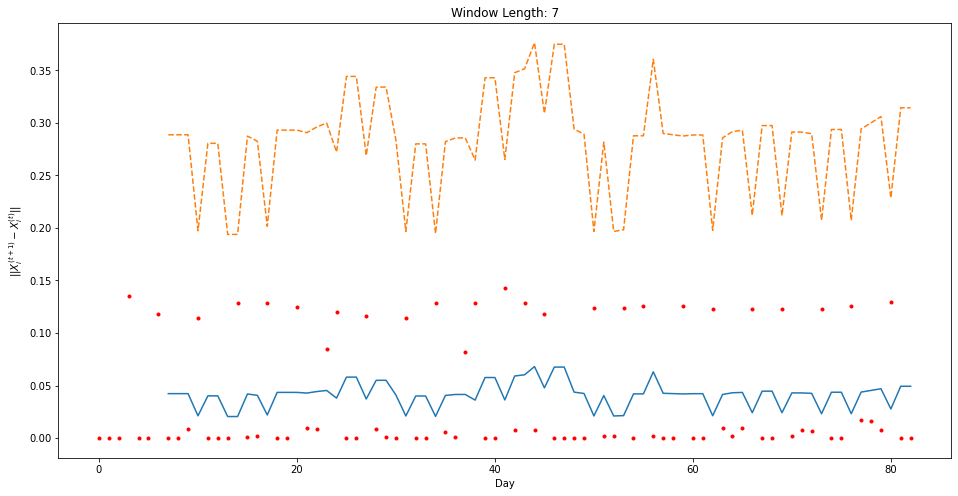

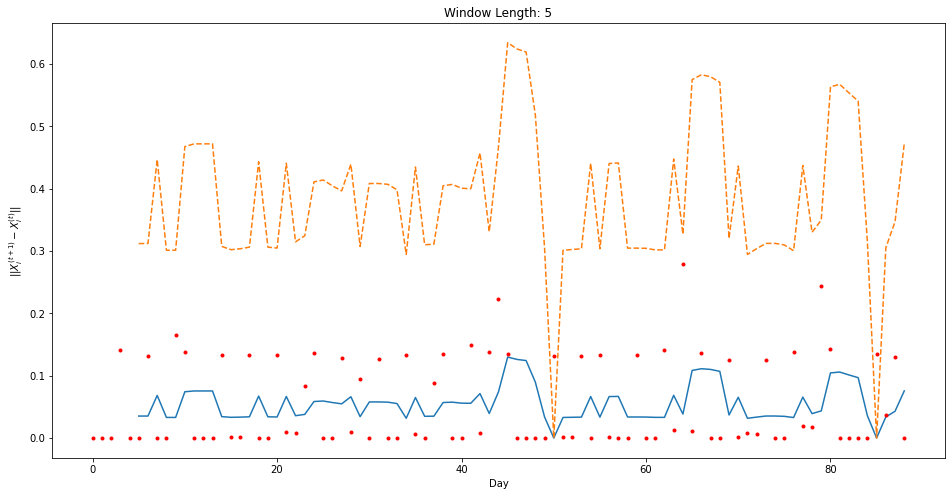

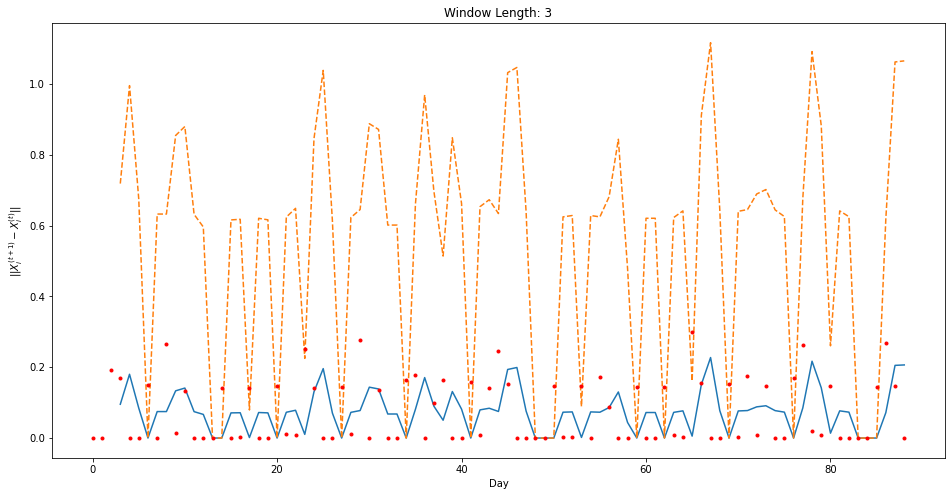

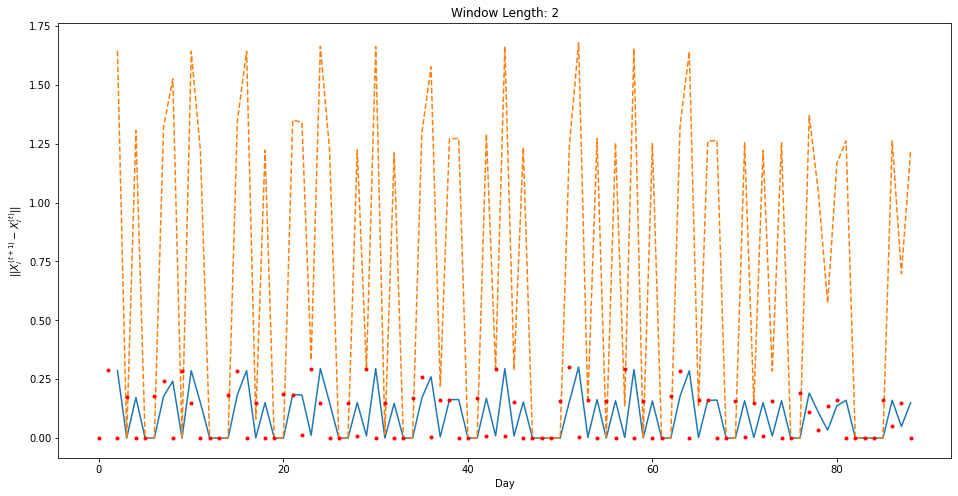

In [89]:
plot_creation_UASE(14,vertex_mam_tracker_14,vertex_range_tracker_14,vertex_norm_tracker_14,idx[1])
plot_creation_UASE(7,vertex_mam_tracker_7,vertex_range_tracker_7,vertex_norm_tracker_7,idx[1])
plot_creation_UASE(5,vertex_mam_tracker_5,vertex_range_tracker_5,vertex_norm_tracker_5,idx[1])
plot_creation_UASE(3,vertex_mam_tracker_3,vertex_range_tracker_3,vertex_norm_tracker_3,idx[1])
plot_creation_UASE(2,vertex_mam_tracker_2,vertex_range_tracker_2,vertex_norm_tracker_2,idx[1])

In [90]:
anomaly_count_rt(day_anomalies_14_U,14)
anomaly_count_rt(day_anomalies_7_U,7)
anomaly_count_rt(day_anomalies_5_U,5)
anomaly_count_rt(day_anomalies_3_U,3)
anomaly_count_rt(day_anomalies_2_U,2)

Using a sliding window of length 14 captures 0.28421052631578947% of rt users as anomalous and 0.5501740947075209% of normal users as anomalous.
Using a sliding window of length 14 captures 27 of 95 rt users as anomalous and 15801 of 28720 normal users as anomalous.
Using a sliding window of length 7 captures 0.5789473684210527% of rt users as anomalous and 0.7139275766016713% of normal users as anomalous.
Using a sliding window of length 7 captures 55 of 95 rt users as anomalous and 20504 of 28720 normal users as anomalous.
Using a sliding window of length 5 captures 0.6631578947368421% of rt users as anomalous and 0.8341225626740947% of normal users as anomalous.
Using a sliding window of length 5 captures 63 of 95 rt users as anomalous and 23956 of 28720 normal users as anomalous.
Using a sliding window of length 3 captures 0.9789473684210527% of rt users as anomalous and 0.9855849582172702% of normal users as anomalous.
Using a sliding window of length 3 captures 93 of 95 rt users 

In [91]:
print(MCC(50,28720-18460,18460,45))
print(MCC(42,28720-19405,19405,53))
print(MCC(65,28720-23900,23900,30))
print(MCC(92,28720-28291,28291,3))
print(MCC(95,28720-28567,28567,0))

(array([35.77997571,  0.27012426, 52.63157895, 64.27576602]), -0.013926307710791378)
(array([32.47267048,  0.21597162, 44.21052632, 67.56615599]), -0.028582213093000287)
(array([16.95297588,  0.27122888, 68.42105263, 83.21727019]), -0.022669667119785533)
(array([ 1.80808607,  0.32413769, 96.84210526, 98.50626741]), -0.007850162332786662)
(array([  0.86066285,   0.33144931, 100.        ,  99.46727019]), 0.004202058114758256)


#### UMAP Visualisations of UASE

In [92]:
import umap

In [93]:
reducer = umap.UMAP()

Plotting.


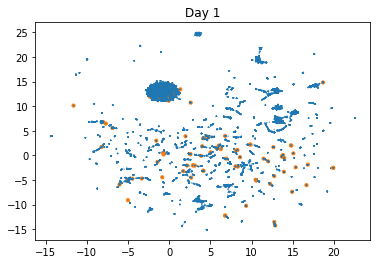

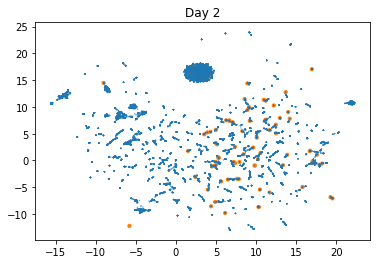

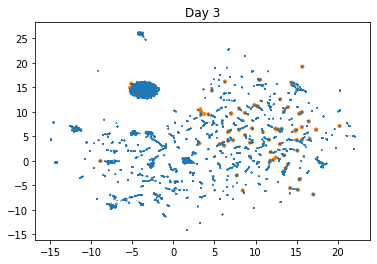

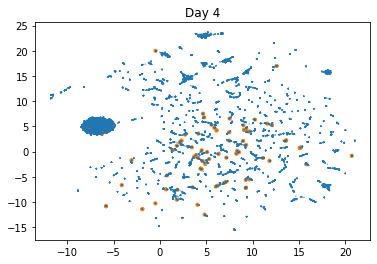

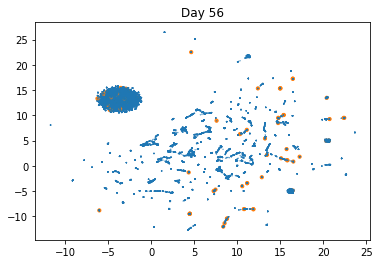

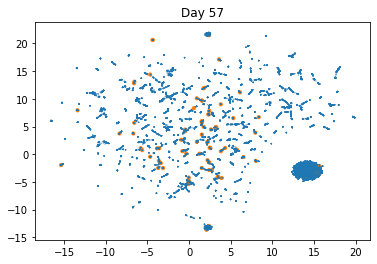

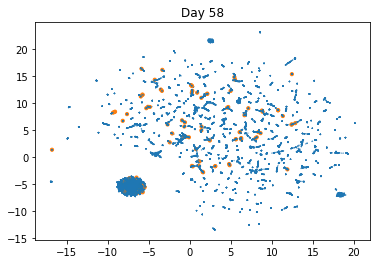

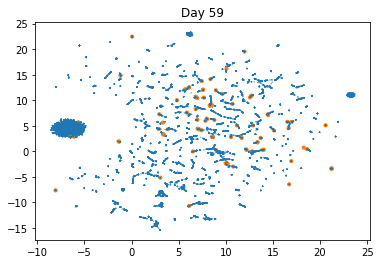

In [145]:
import warnings
from collections import defaultdict
warnings.filterwarnings("ignore", message="WARNING: spectral initialisation failed! ")
window_length=7
weeks = int(len(data_frame_list_uase)/window_length)

Y_arrays = []

for i in range(weeks):
    matrices = []
    for j in range(window_length):
        matrices.append(data_frame_list_uase[i*window_length+j])

    wl_matrix = scipy.sparse.hstack(matrices)

    u, s, v = scipy.sparse.linalg.svds(wl_matrix.asfptype(),k=7)

    for j in range(window_length):
        v_j = pd.DataFrame(v).iloc[: ,28815*j:28815*(j+1)]
        Y = pd.DataFrame((v_j.transpose()*s**0.5).transpose())
        Y_arrays.append(Y)

rt_bool = []
s = []
for un in list(columns_sparse):
    if un in rt_usernames:
        rt_bool.append(1)
        s.append(10)
    else:
        rt_bool.append(0)
        s.append(0.1)
        
print('Plotting.')
days = [0,1,2,3,55,56,57,58]
for d in days:
    embedding = reducer.fit_transform(np.array(Y_arrays[d]).transpose())
    plt.figure()
    plt.scatter(embedding[:, 0], embedding[:, 1],c=[sns.color_palette()[x] for x in rt_bool],s=s)
    plt.title('Day {}'.format(d+1))
    plt.show()

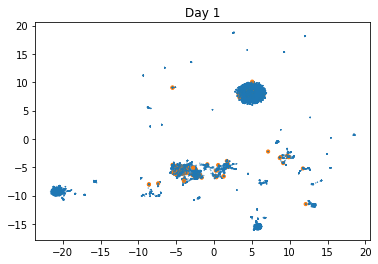

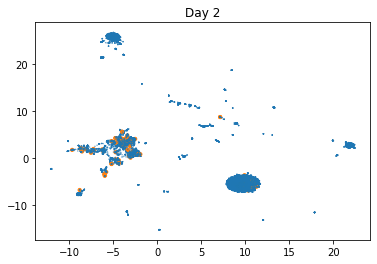

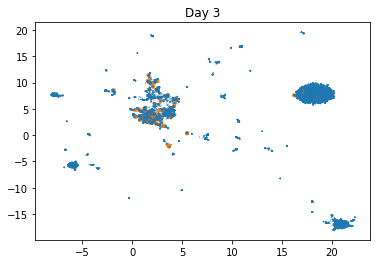

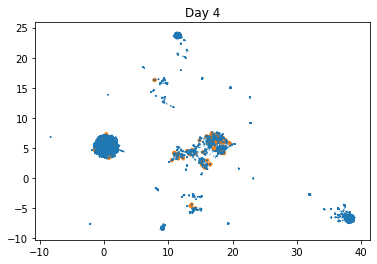

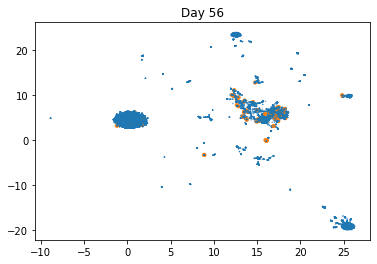

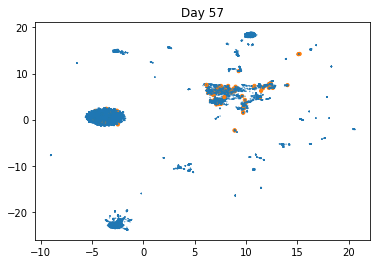

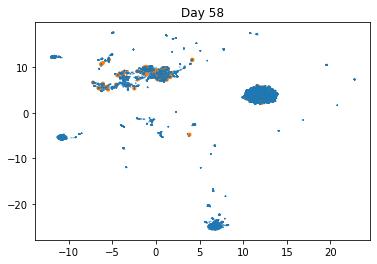

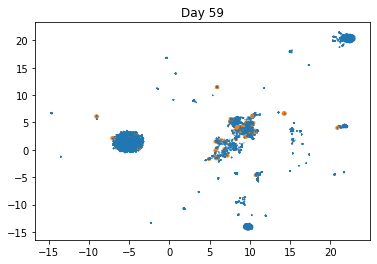

In [151]:
for d in days:
    embedding = reducer.fit_transform(scipy.sparse.csr_matrix(data_frame_list_uase[0].todense().transpose()))
    plt.figure()
    plt.scatter(embedding[:, 0], embedding[:, 1],c=[sns.color_palette()[x] for x in rt_bool],s=s)
    plt.title('Day {}'.format(d+1))
    plt.show()

### Combining Anomaly Detection Techniques

Our final anomalies are determined by the overlap of our poisson model and our autoencoder, combining two different data sets and two different anomaly detection methods in the hope that this reduces our false positive rate somewhat.

In [42]:
final_anomalies = pd.merge(anomalies_ae_5, poisson_anoms_inhom, how='inner', on=list(poisson_anoms.columns))
final_normal_anomalies = pd.merge(anomalies_ae_n_5, inhom_poisson_anoms_n, how='inner', on=list(poisson_anoms.columns))

In [43]:
final_anom_bool_n = []
final_anom_bool = []

for un in non_rt_sample:
    if un in list(final_normal_anomalies['UserName']):
        final_anom_bool_n.append((1,un))
    else:
        final_anom_bool_n.append((0,un))
for un in set(rt_usernames):
    if un in list(final_anomalies['UserName']):
        final_anom_bool.append((1,un))
    else:
        final_anom_bool.append((0,un))
simple_poiss_eval(final_anom_bool,final_anomalies,rt_usernames,'red team')
simple_poiss_eval(final_anom_bool_n,final_normal_anomalies,non_rt_sample,'normal')

81 of the red team usernames were identified to have anomalies out of 95 red team usernames. The folloiwng usernames were found to have no anomalies
--------------------------------------------------------------------------------------------
User497510, User133028, User829941, User630088, User758916, User409683, User089536, User457932, User859748, User702833, User405399, User370789, User900703, User222822
13.44% of the red team data was identified as anomalous.
Authent Type
Batch                    374
CachedInteractive         40
InteractiveLogon         636
NetworkLogon            4594
RemoteInteractive        134
ScreensaverDismissed     318
ScreensaverInvoked       306
Service                  907
TGS                     9124
TGT                     2482
WorkstationLock          747
WorkstationUnlock        750
dtype: int64
156 of the normal usernames were identified to have anomalies out of 200 normal usernames. The folloiwng usernames were found to have no anomalies
-------------

In [65]:
MCC(81,44,156,14)

(array([42.37288136, 34.17721519, 85.26315789, 78.        ]),
 0.08539139650499467)

In [46]:
final_anomalies.to_csv('Final Anomalies (AE IPOIS).gz', compression='gzip')
final_normal_anomalies.to_csv('Final Normal Anomalies (AE IPOIS).gz', compression='gzip')

#### Checking that the random sample is a 'good sample'

In [47]:
full_check = np.array(list(authentication_data.groupby('UserName').size()))
sample_check = np.array(list(authentication_data[authentication_data['UserName'].isin(non_rt_sample)].groupby('UserName').size()))

In [48]:
def describe(data):
    mx = data.max()
    mn = data.min()
    mean = data.mean()
    median = np.median(data)
    q_25, q_75 = np.quantile(data,q=[0.25,0.75])
    std = np.std(data)
    return [mean,std,mn,q_25,median,q_75,mx]

In [49]:
np.quantile(full_check,q=[0.999])

array([3973.46])

In [50]:
a = describe(full_check)
b = describe(sample_check)
pd.DataFrame([a,b],columns = ['mean','std','min','25%','median','75%','max'],index=['Full Data Frame','Non Red Team Sample']).transpose()

,Full Data Frame,Non Red Team Sample
mean,553.658893,471.165000
std,3049.364235,459.627053
min,1.000000,1.000000
25%,119.000000,119.750000
median,403.000000,376.000000
75%,735.000000,642.000000
max,472595.000000,2667.000000


So as a check, we seem to get a good sample of the data using the non red team sample which is what we hoped to achieve. The mean of the sample is fairly close to the mean of , way within 1 std of the original mean and standard deviation. The other results are all very similar landing within +/- 10 of the full results roughly which is a good sign that it is a good representation. The maximum is way off but due to the outliers in the original data set this isn't unsurprising and likely has little effect on the results so we can assume they are fairly accurate. 

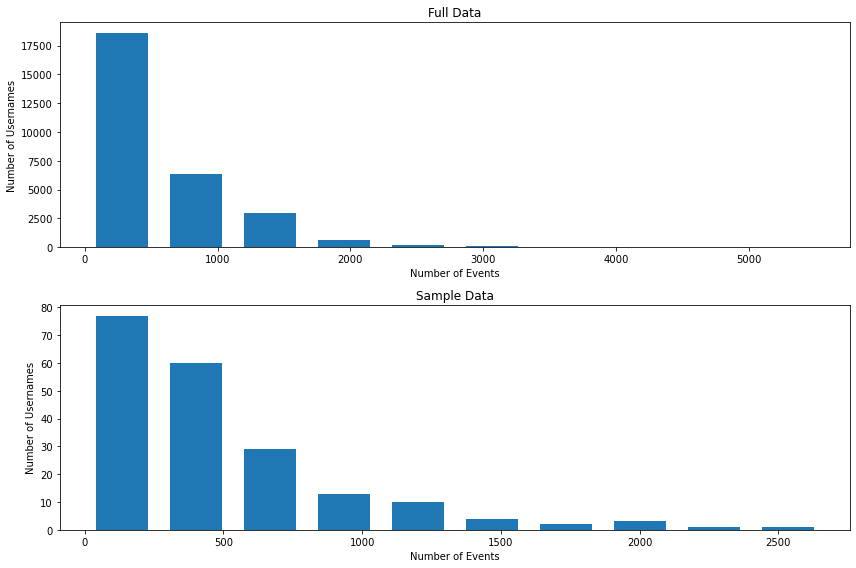

In [51]:
fig,ax = plt.subplots(2,1,figsize=(12,8))
ax[0].hist([i for i in full_check if i <= 6000],rwidth=0.7)
ax[1].hist(sample_check,rwidth=0.7)
ax[0].set_ylabel('Number of Usernames')
ax[0].set_xlabel('Number of Events')
ax[0].set_title('Full Data')
ax[1].set_ylabel('Number of Usernames')
ax[1].set_xlabel('Number of Events')
ax[1].set_title('Sample Data')
fig.tight_layout()
plt.show()
fig.savefig('C:/Users/corri/OneDrive/Documents/Uni/Postgraduate/Final Project/Number of Events.png')

Plotting histograms is a final sanity check for us. Since the highest results in the sample is ~6000 and the outliers in the full dataframe make the histograms almost incomprehensible, we limit the full check to a maximum of 6000 which encompases more than 99.9% of data. This shows that the distributions match almost exactly and is a really good sign that we got a good sample. 

In [52]:
full_type_check_index = authentication_data.groupby('Authent Type').size().sort_values(ascending=False).index
full_type_check = np.array(list(authentication_data.groupby('Authent Type').size().sort_values(ascending=False)))

In [53]:
sample_type_check_index = authentication_data[authentication_data['UserName'].isin(non_rt_sample)].groupby('Authent Type').size().sort_values(ascending=False).index
sanple_type_check = np.array(list(authentication_data[authentication_data['UserName'].isin(non_rt_sample)].groupby('Authent Type').size().sort_values(ascending=False)))

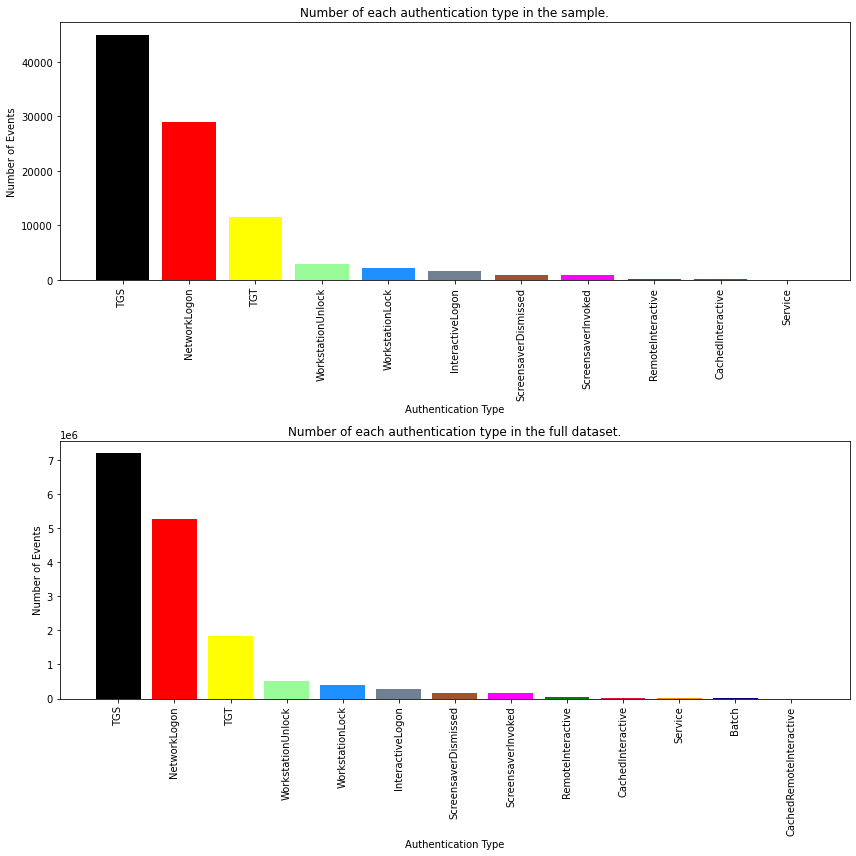

In [54]:
colors = ['black','red','yellow','palegreen','dodgerblue','slategrey','sienna','magenta','green','crimson','darkorange','navy','bisque']

fig,ax = plt.subplots(2,1,figsize=(12,12))
ax[0].bar(x=sample_type_check_index,height=sanple_type_check, color=colors)
ax[0].set_xlabel('Authentication Type')
ax[0].set_ylabel('Number of Events')
ax[0].set_title('Number of each authentication type in the sample.')

ax[1].bar(x=full_type_check_index,height=full_type_check, color=colors)
ax[1].set_xlabel('Authentication Type')
ax[1].set_ylabel('Number of Events')
ax[1].set_title('Number of each authentication type in the full dataset.')

for ax in fig.axes:
    plt.sca(ax)
    plt.xticks(rotation=90)
plt.tight_layout()
fig.savefig('C:/Users/corri/OneDrive/Documents/Uni/Postgraduate/Final Project/Number of AT.png')
plt.show()

Similarly, the authentication types contained within the sample follow a very similar pattern to the full dataset with a few small differences in the ordering of the smaller authentication types. In general though the trend is correct.